<h1 style="font-size: 44px; color: red;">For model fitting, see closer to the bottom</h1>

# Import Libraries

In [110]:
import pandas as pd
import math
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
from statsmodels.formula.api import ols

from sklearn import datasets, tree
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.feature_selection import SelectKBest, chi2, VarianceThreshold, RFE
from sklearn.svm import SVC
from sklearn.cross_validation import train_test_split

import matplotlib.pylab as pylab

# Read in cleaned data from wrangling portion.

In [71]:
ucb_w_reindex = pd.read_csv('clean_airbnb.csv')
ucb = pd.read_csv('clean_airbnb.csv')

# Remove  browsers used that are insignificant

In [72]:
orig_ucb = ucb
ucb = ucb.loc[ucb['first_browser'] != 'Opera']
ucb = ucb.loc[ucb['first_browser'] != 'AOL Explorer']
ucb = ucb.loc[ucb['first_browser'] != 'Chromium']
ucb = ucb.loc[ucb['first_browser'] != 'Silk']
ucb = ucb.loc[ucb['first_browser'] != 'BlackBerry Browser']
ucb = ucb.loc[ucb['first_browser'] != 'Apple Mail']
ucb = ucb.loc[ucb['first_browser'] != 'RockMelt']
ucb = ucb.loc[ucb['first_browser'] != 'Mobile Firefox']
ucb = ucb.loc[ucb['first_browser'] != 'Maxthon']
ucb = ucb.loc[ucb['first_browser'] != 'IceWeasel']
ucb = ucb.loc[ucb['first_browser'] != 'Camino']
ucb = ucb.loc[ucb['first_browser'] != 'Sogou Explorer']
ucb = ucb.loc[ucb['first_browser'] != 'Iron']
ucb = ucb.loc[ucb['first_browser'] != 'CoolNovo']
ucb = ucb.loc[ucb['first_browser'] != 'SiteKiosk']
ucb = ucb.loc[ucb['first_browser'] != 'Pale Moon']
ucb = ucb.loc[ucb['first_browser'] != 'TheWorld Browser']
ucb = ucb.loc[ucb['first_browser'] != 'wOSBrowser']
ucb = ucb.loc[ucb['first_browser'] != 'NetNewsWire']
ucb = ucb.loc[ucb['first_browser'] != 'Mozilla']
ucb = ucb.loc[ucb['first_browser'] != 'CometBird']
ucb = ucb.loc[ucb['first_browser'] != 'Opera Mini']
ucb = ucb.loc[ucb['first_browser'] != 'TenFourFox']
ucb = ucb.loc[ucb['first_browser'] != 'Stainless']
ucb = ucb.loc[ucb['first_browser'] != 'IE Mobile']
ucb.columns

Index(['country_destination', 'gender', 'dest_age_pop', 'age', 'id',
       'date_account_created', 'timestamp_first_active', 'date_first_booking',
       'signup_method', 'signup_flow', 'language', 'affiliate_channel',
       'affiliate_provider', 'first_affiliate_tracked', 'signup_app',
       'first_device_type', 'first_browser', 'lat_destination',
       'lng_destination', 'distance_km', 'destination_km2',
       'destination_language ', 'US', 'FR', 'IT', 'GB', 'ES', 'CA', 'DE', 'NL',
       'AU', 'PT'],
      dtype='object')

# Possible Trends
* ### Look for some correlation between the country visited and age/gender
* ### Is there some connection with the country visited, and the first browser used when going to the site ?
* ### Is there some relation to different types of users, and the distance traveled to go to their destination (e.g. Young males might usually travel farther from home than older females.)
* ### Does some demographic of user have to do with the size of the country they visit, or the size of the population similar to them (Same age, same gender)
* ### Does activity in the user's session (Changing their account, browsing countries) determine where the user might end up going ?
* ### Is it possible to use a time series for dates that accounts were created to see some trend over time with ? possibly use a stacked bar graph to see the number of users visiting each of the 10 countries on a week by week basis.

## Time Series

In [73]:
ucb_w_reindex['date_account_created'] = pd.to_datetime(ucb['date_account_created'])
ucb_w_reindex = ucb_w_reindex.sort_values('date_account_created')
ucb_w_reindex = ucb_w_reindex.set_index('date_account_created')

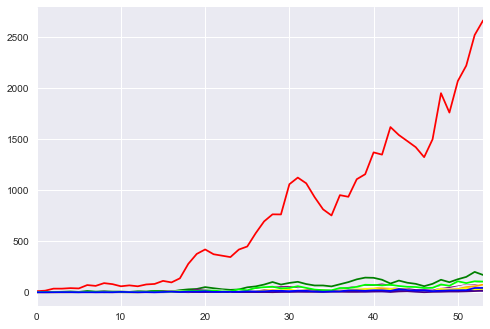

In [74]:
us_m_ot = ucb_w_reindex.US.resample('M').sum()
fr_m_ot = ucb_w_reindex.FR.resample('M').sum()
au_m_ot = ucb_w_reindex.AU.resample('M').sum()
ca_m_ot = ucb_w_reindex.CA.resample('M').sum()
de_m_ot = ucb_w_reindex.DE.resample('M').sum()
es_m_ot = ucb_w_reindex.ES.resample('M').sum()
pt_m_ot = ucb_w_reindex.PT.resample('M').sum()
gb_m_ot = ucb_w_reindex.GB.resample('M').sum()
it_m_ot = ucb_w_reindex.IT.resample('M').sum()
nl_m_ot = ucb_w_reindex.NL.resample('M').sum()

sns.tsplot(data=us_m_ot, color='red')
sns.tsplot(data=fr_m_ot, color='green')
sns.tsplot(data=au_m_ot, color='blue')
sns.tsplot(data=ca_m_ot, color='orange')
sns.tsplot(data=de_m_ot, color='yellow')
sns.tsplot(data=es_m_ot, color='purple')
sns.tsplot(data=pt_m_ot, color='indigo')
sns.tsplot(data=gb_m_ot, color='white')
sns.tsplot(data=it_m_ot, color='lime')
sns.tsplot(data=nl_m_ot, color='blue')
plt.show()

## Bookings to the United States over time are clearly getting more prevalant

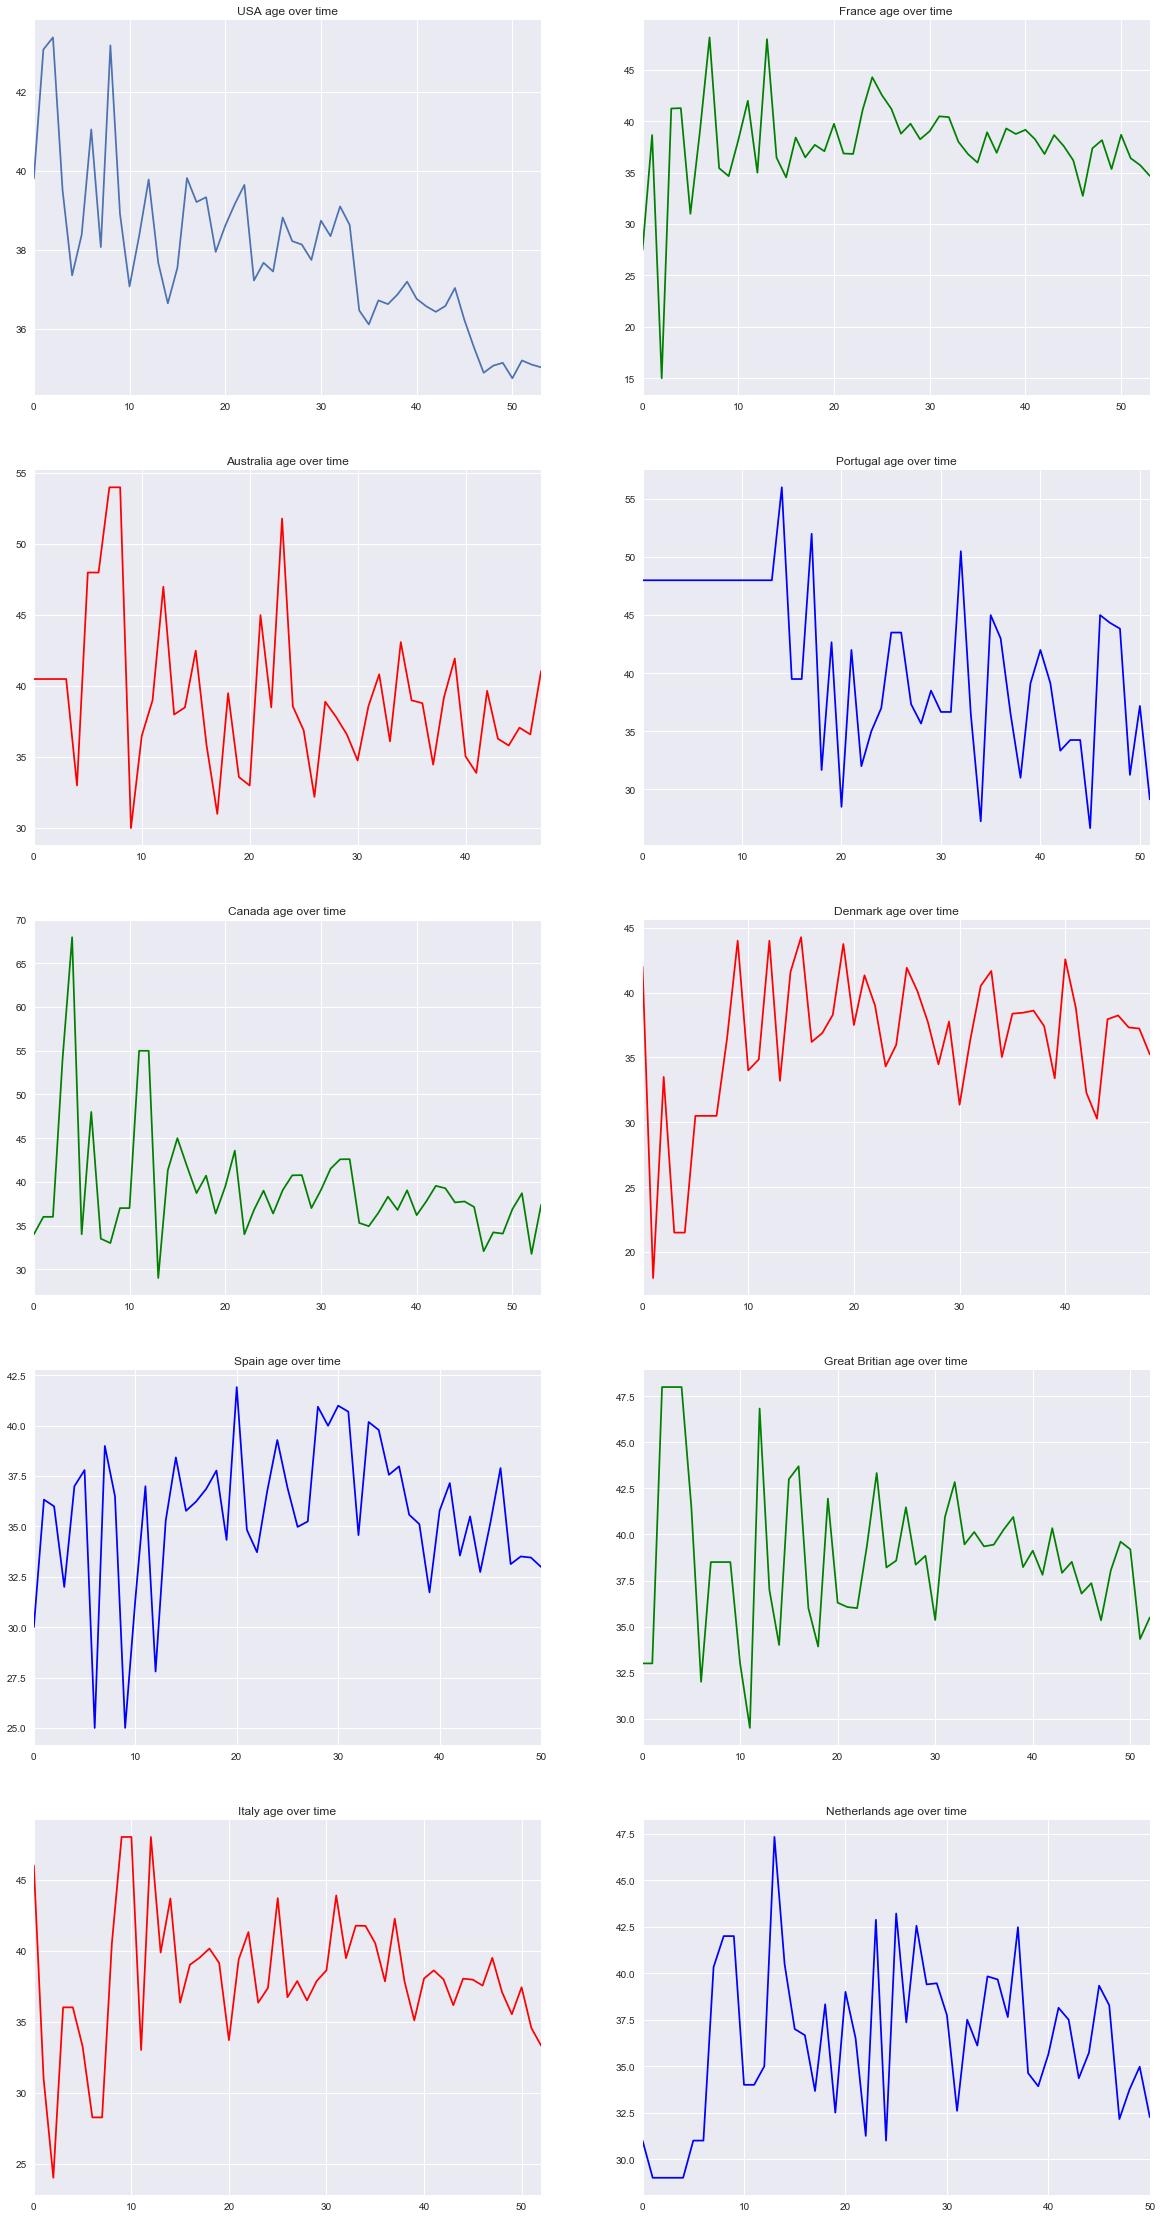

In [75]:
us_age_over_time = ucb_w_reindex.loc[ucb_w_reindex['country_destination'] == 'US'].age.resample('M').mean().fillna(method='ffill')
fr_age_over_time = ucb_w_reindex.loc[ucb_w_reindex['country_destination'] == 'FR'].age.resample('M').mean().fillna(method='ffill')
au_age_over_time = ucb_w_reindex.loc[ucb_w_reindex['country_destination'] == 'AU'].age.resample('M').mean().fillna(method='ffill')
pt_age_over_time = ucb_w_reindex.loc[ucb_w_reindex['country_destination'] == 'PT'].age.resample('M').mean().fillna(method='ffill')
ca_age_over_time = ucb_w_reindex.loc[ucb_w_reindex['country_destination'] == 'CA'].age.resample('M').mean().fillna(method='ffill')
de_age_over_time = ucb_w_reindex.loc[ucb_w_reindex['country_destination'] == 'DE'].age.resample('M').mean().fillna(method='ffill')
es_age_over_time = ucb_w_reindex.loc[ucb_w_reindex['country_destination'] == 'ES'].age.resample('M').mean().fillna(method='ffill')
gb_age_over_time = ucb_w_reindex.loc[ucb_w_reindex['country_destination'] == 'GB'].age.resample('M').mean().fillna(method='ffill')
it_age_over_time = ucb_w_reindex.loc[ucb_w_reindex['country_destination'] == 'IT'].age.resample('M').mean().fillna(method='ffill')
nl_age_over_time = ucb_w_reindex.loc[ucb_w_reindex['country_destination'] == 'NL'].age.resample('M').mean().fillna(method='ffill')

num_plots = 10
fig, axes = plt.subplots(5,2,figsize=(20,40))

sns.tsplot(data=us_age_over_time, ax=axes[0, 0])
axes[0, 0].set_title('USA age over time')

sns.tsplot(data=fr_age_over_time, color='green', ax=axes[0, 1])
axes[0, 1].set_title('France age over time')

sns.tsplot(data=au_age_over_time, color='red', ax=axes[1, 0])
axes[1, 0].set_title('Australia age over time')

sns.tsplot(data=pt_age_over_time, color='blue', ax=axes[1, 1])
axes[1, 1].set_title('Portugal age over time')

sns.tsplot(data=ca_age_over_time, color='green', ax=axes[2, 0])
axes[2, 0].set_title('Canada age over time')

sns.tsplot(data=de_age_over_time, color='red', ax=axes[2, 1])
axes[2, 1].set_title('Denmark age over time')

sns.tsplot(data=es_age_over_time, color='blue', ax=axes[3, 0])
axes[3, 0].set_title('Spain age over time')

sns.tsplot(data=gb_age_over_time, color='green', ax=axes[3, 1])
axes[3, 1].set_title('Great Britian age over time')

sns.tsplot(data=it_age_over_time, color='red', ax=axes[4, 0])
axes[4, 0].set_title('Italy age over time')

sns.tsplot(data=nl_age_over_time, color='blue', ax=axes[4, 1])
axes[4, 1].set_title('Netherlands age over time')
plt.show()

## It is hard to tell any trend with some of these plots, but we can see that most countries are now seeming to see younger and younger ages making bookings. Especially in the United States.

In [89]:
def getMonth(row):
    months = {
        '01': 'January',
        '02': 'February',
        '03': 'March',
        '04': 'April',
        '05': 'May',
        '06': 'June',
        '07': 'July',
        '08': 'August',
        '09': 'September',
        '10': 'October',
        '11': 'November',
        '12': 'December'
    }
    
    month = str(row['date_account_created']).split('-')[1]
    return int(month)
    
ucb['month'] = ucb.apply(lambda x: getMonth(x), axis=1)
ucb.head(5)

,country_destination,gender,dest_age_pop,age,id,date_account_created,timestamp_first_active,date_first_booking,signup_method,signup_flow,...,FR,IT,GB,ES,CA,DE,NL,AU,PT,month
0,AU,male,415000,71,e2jv79axh0,2014-01-13,20140113191425,2014-01-13,basic,0,...,0,0,0,0,0,0,0,1,0,1
1,AU,male,415000,73,5uzn5yqyz6,2012-10-21,20121021012712,2012-10-21,facebook,12,...,0,0,0,0,0,0,0,1,0,10
2,AU,male,574000,68,1xc8hpc77c,2013-10-08,20131008180536,2013-10-09,basic,0,...,0,0,0,0,0,0,0,1,0,10
3,AU,male,574000,69,6v9qw4yev2,2014-02-03,20140203180026,2014-02-04,facebook,0,...,0,0,0,0,0,0,0,1,0,2
4,AU,male,636000,62,ewv7zn4r7k,2014-03-01,20140301172819,2014-03-12,facebook,0,...,0,0,0,0,0,0,0,1,0,3


/Users/timothybaney/anaconda/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


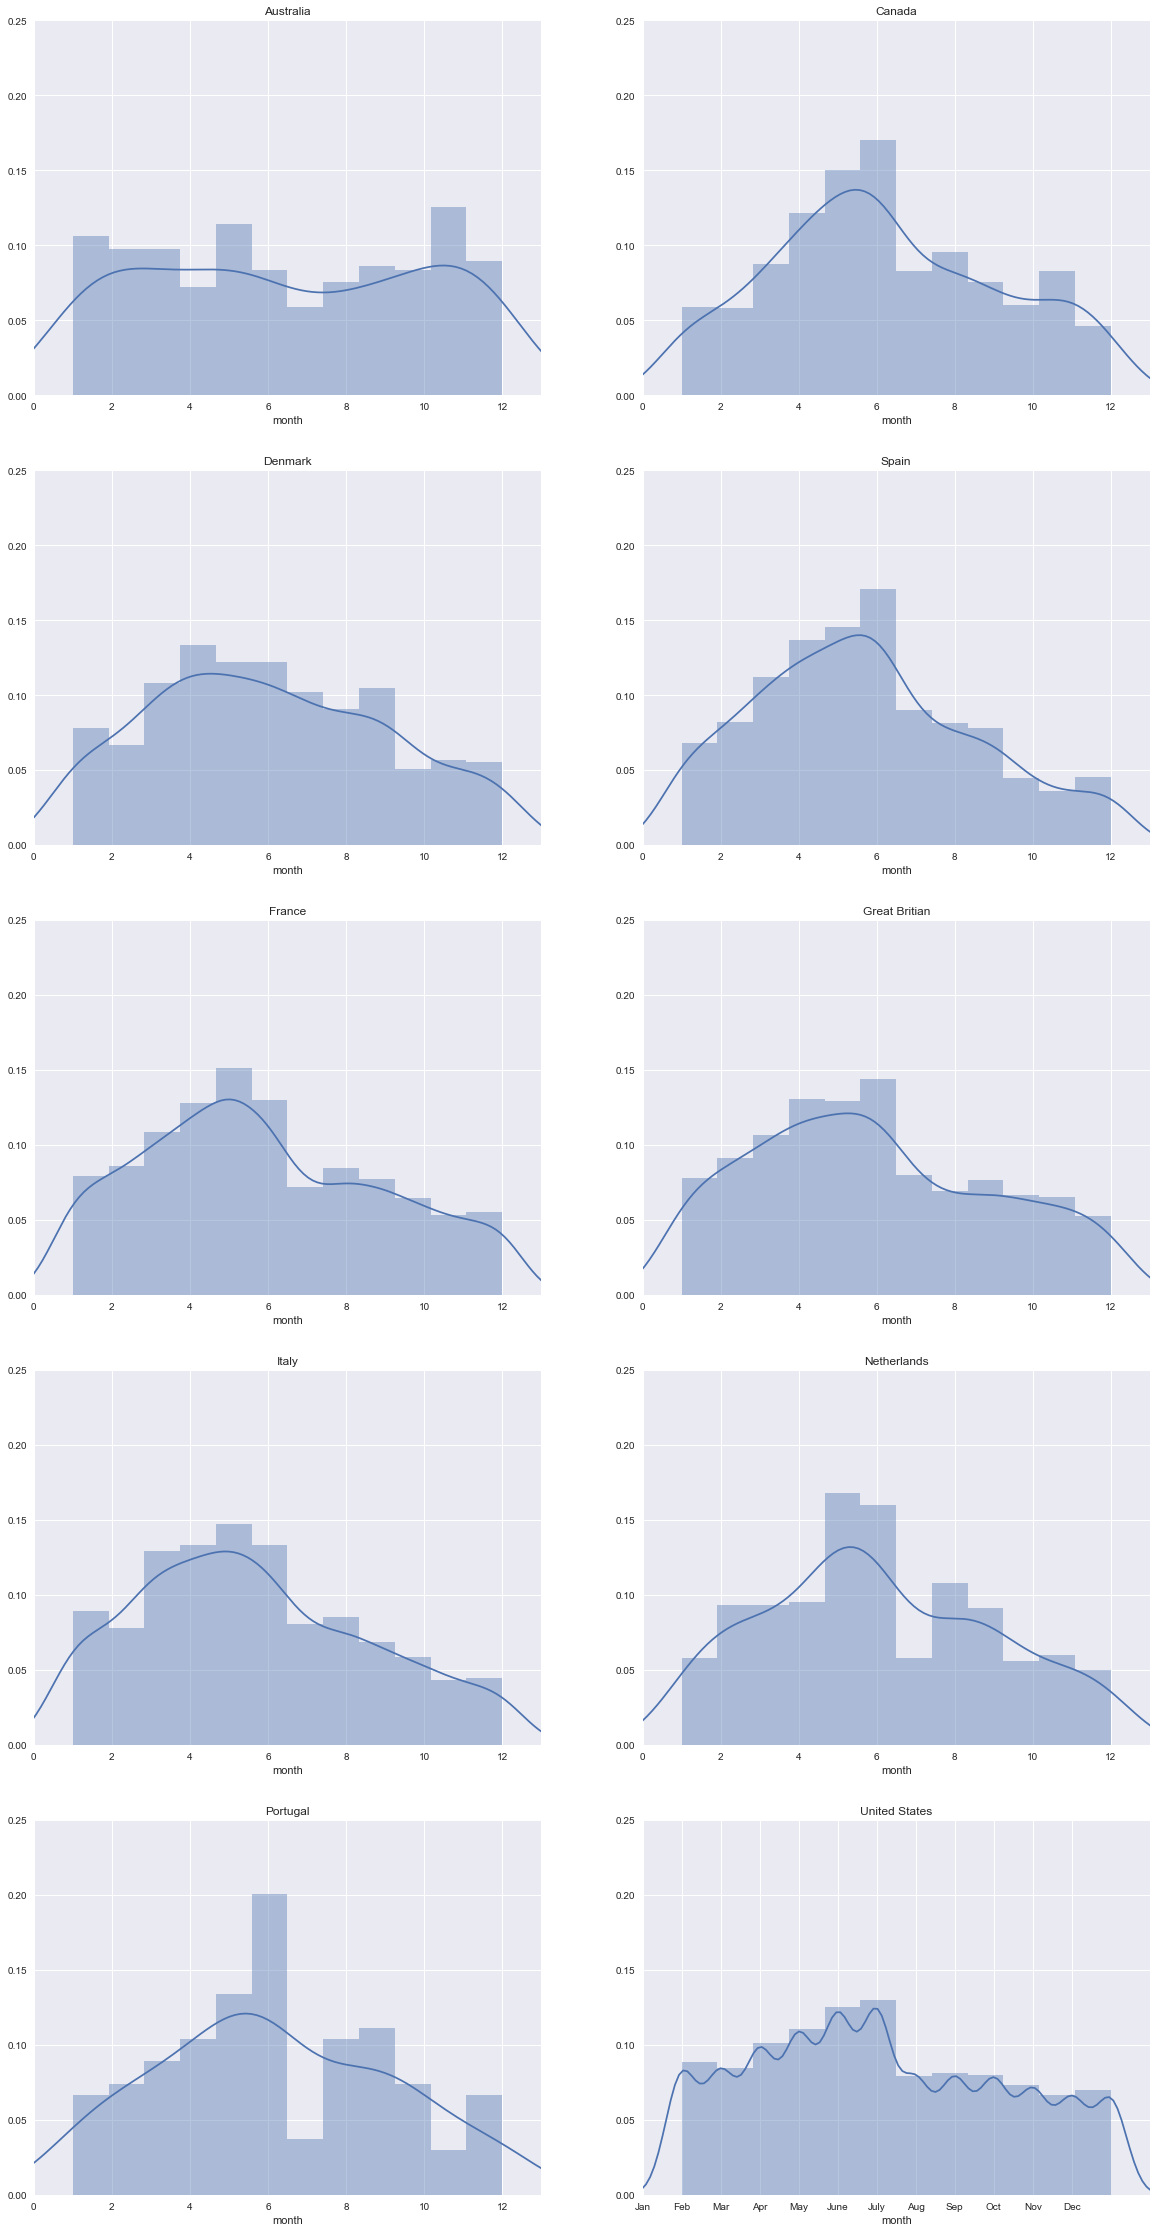

In [108]:
full_country_name = {
    'US': 'United States',
    'FR': 'France',
    'DE': 'Denmark',
    'CA': 'Canada',
    'AU': 'Australia',
    'ES': 'Spain',
    'PT': 'Portugal',
    'IT': 'Italy',
    'GB': 'Great Britian',
    'NL': 'Netherlands'
}

num_plots = 10
fig, axes = plt.subplots(5,2,figsize=(20,40))

def buckets(i):
    return [ucb.country_destination.unique()[i]]

# iterate through all axes and create a violin plot
for i in range(num_plots):
    data = ucb[ucb.country_destination.isin(buckets(i))]
    x = data['month']
    
    objects = ('Jan', 'Feb', 'Mar', 'Apr', 'May', 'June', 'July', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec')
    y_pos = np.arange(len(objects))
    
    row = i // 2
    col = i % 2
    ax_curr = axes[row, col]
    
    title = full_country_name[buckets(i)[0]]
    
    sns.distplot(x, bins=12, ax=ax_curr)
    plt.title('Canada')
    ax_curr.set_title(title)
    ax_curr.set_ylim([0, .25])
    ax_curr.set_xlim([0, 13])

    plt.xticks(y_pos, objects)

plt.show()

# One thing to note here is that users who create their account from October to February are more likely to go to countries in the southern hemisphere as the seasons are inversed there, and users like to go places in the summer.

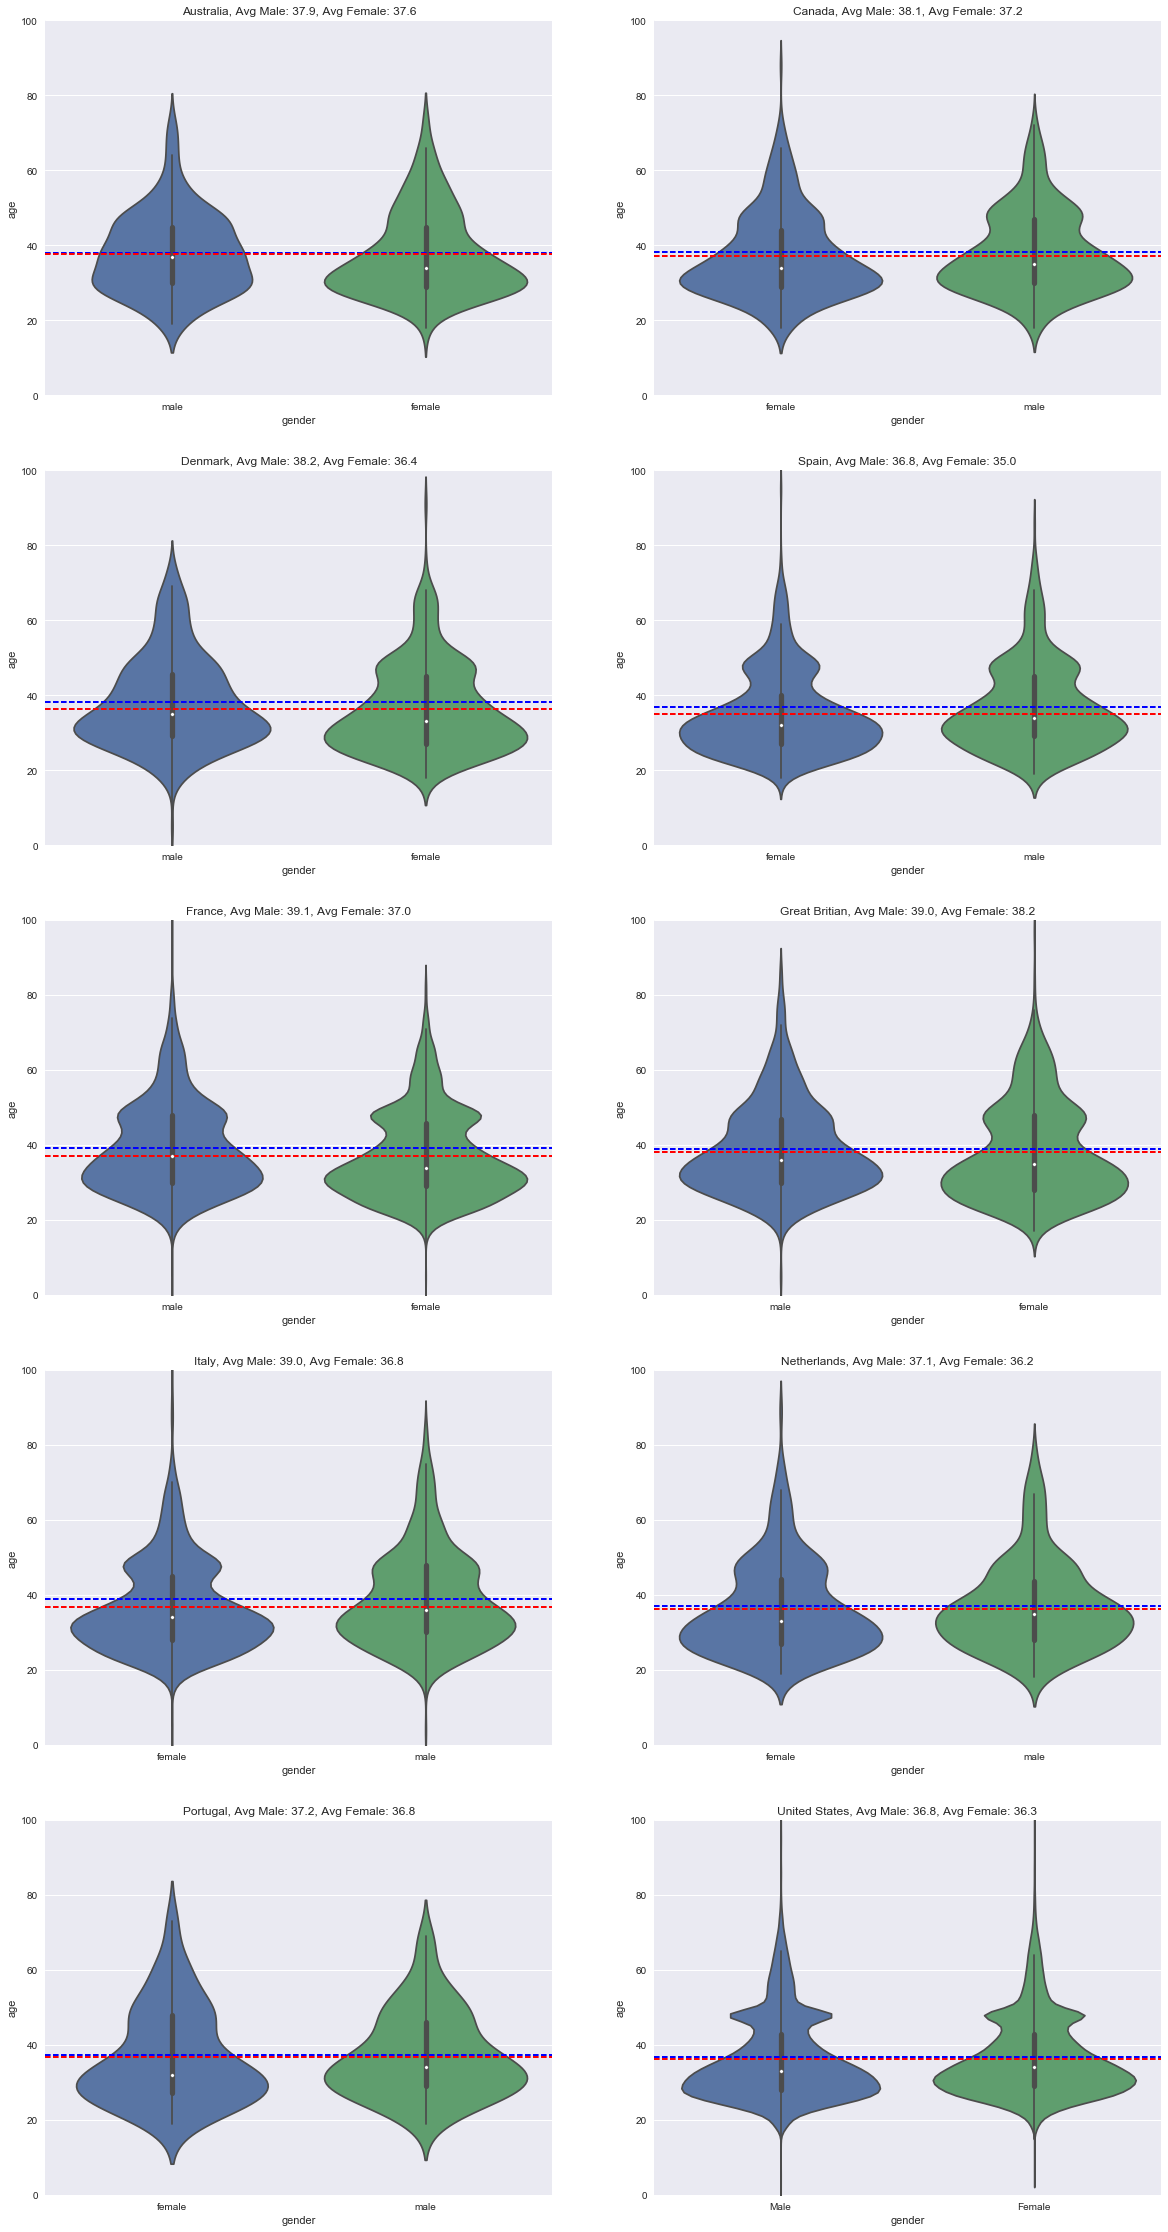

In [7]:
full_country_name = {
    'US': 'United States',
    'FR': 'France',
    'DE': 'Denmark',
    'CA': 'Canada',
    'AU': 'Australia',
    'ES': 'Spain',
    'PT': 'Portugal',
    'IT': 'Italy',
    'GB': 'Great Britian',
    'NL': 'Netherlands'
}

num_plots = 10
fig, axes = plt.subplots(5,2,figsize=(20,40))

def buckets(i):
    return [ucb.country_destination.unique()[i]]

# iterate through all axes and create a violin plot
for i in range(num_plots):
    data = ucb[ucb.country_destination.isin(buckets(i))]
    
    male_mean = round(data.loc[data['gender'] == 'male'].age.mean(), 1)
    female_mean = round(data.loc[data['gender'] == 'female'].age.mean(), 1)
    
    objects = ('Male', 'Female')
    y_pos = np.arange(len(objects))
    
    row = i // 2
    col = i % 2
    ax_curr = axes[row, col]
    
    title = full_country_name[buckets(i)[0]]
        
    sns.violinplot(x="gender", y="age", data=data, ax=ax_curr)
    ax_curr.set_title('{}, Avg Male: {}, Avg Female: {}'.format(title, male_mean, female_mean))
    ax_curr.set_ylim([0, 100])
    ax_curr.axhline(male_mean, color='b', linestyle='dashed', linewidth=2)
    ax_curr.axhline(female_mean, color='r', linestyle='dashed', linewidth=2)

    plt.xticks(y_pos, objects)

plt.show()

## Unfortunately, this doesn't show us much since there a lot of variance between genders for a country.

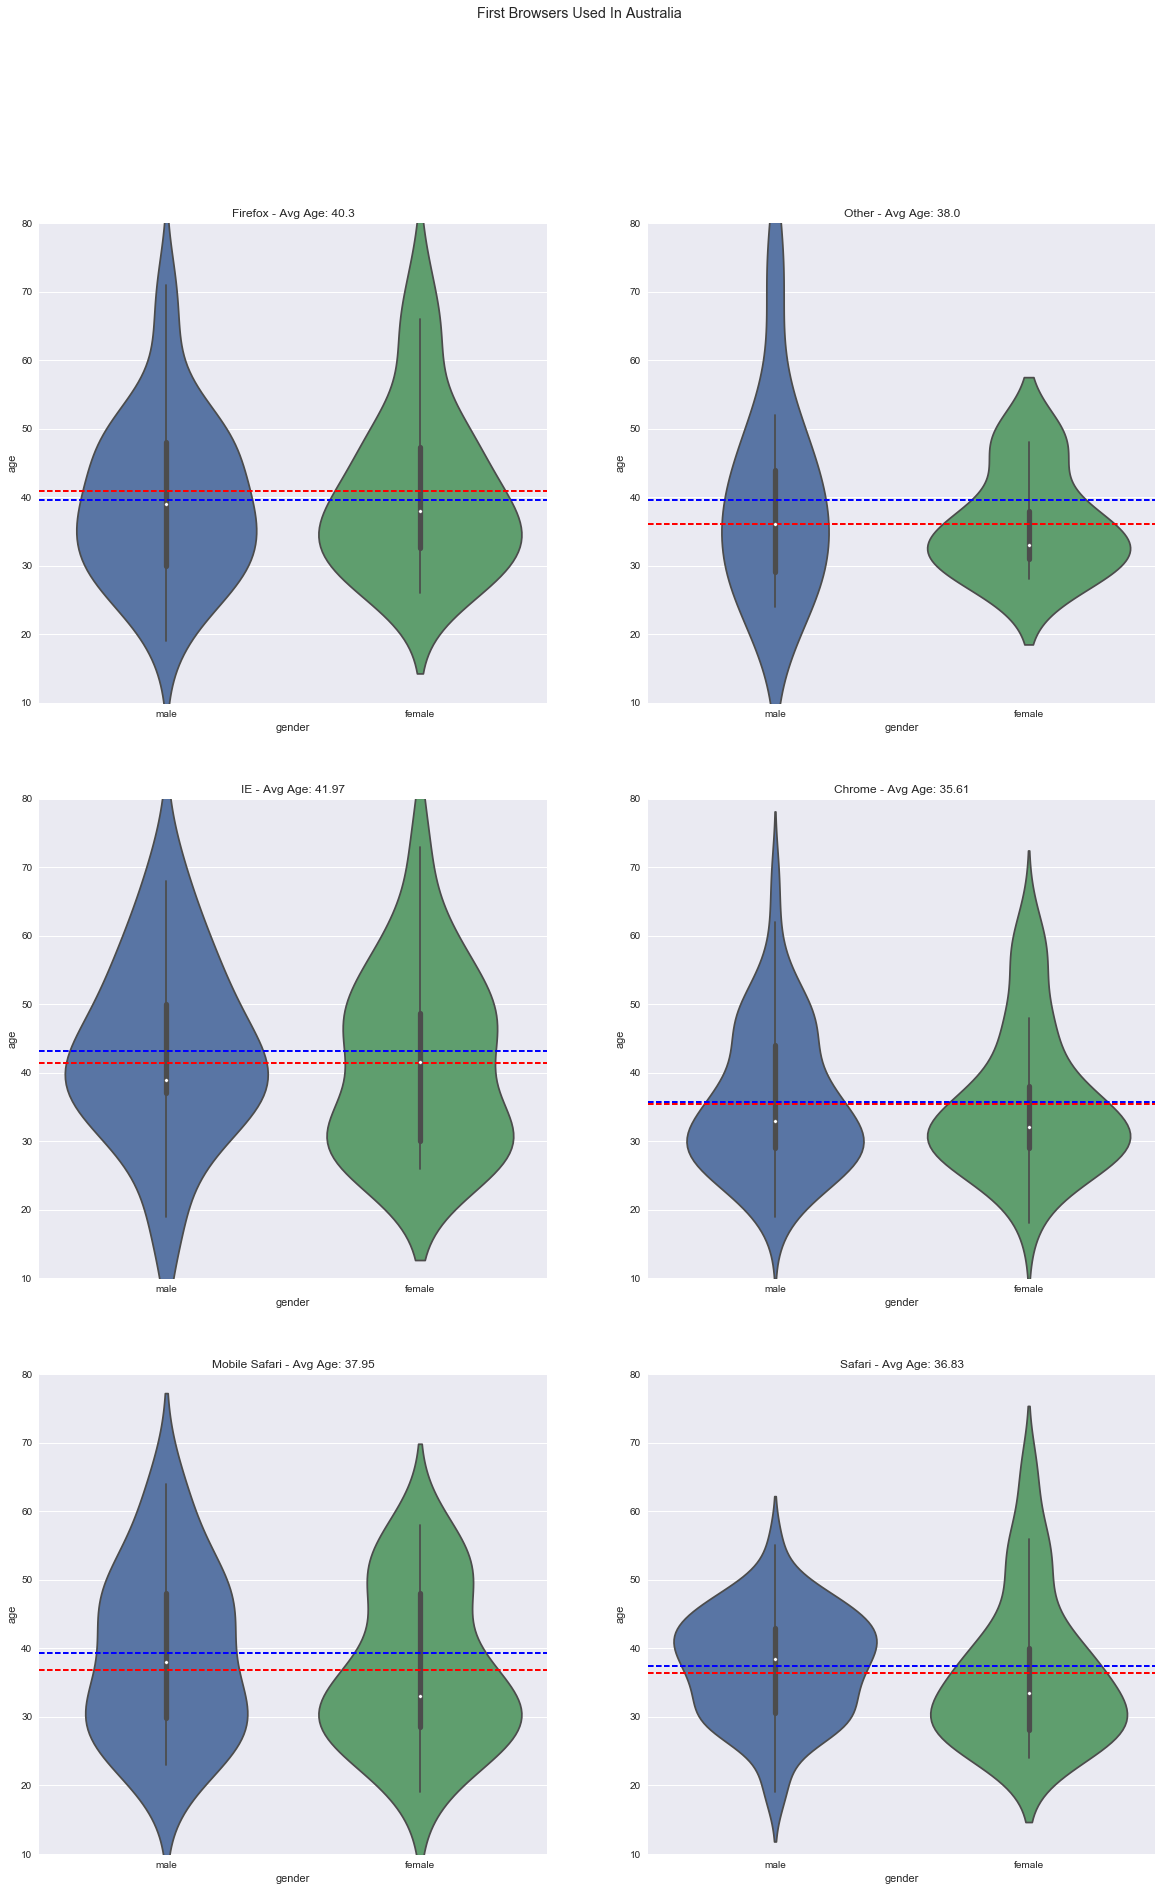

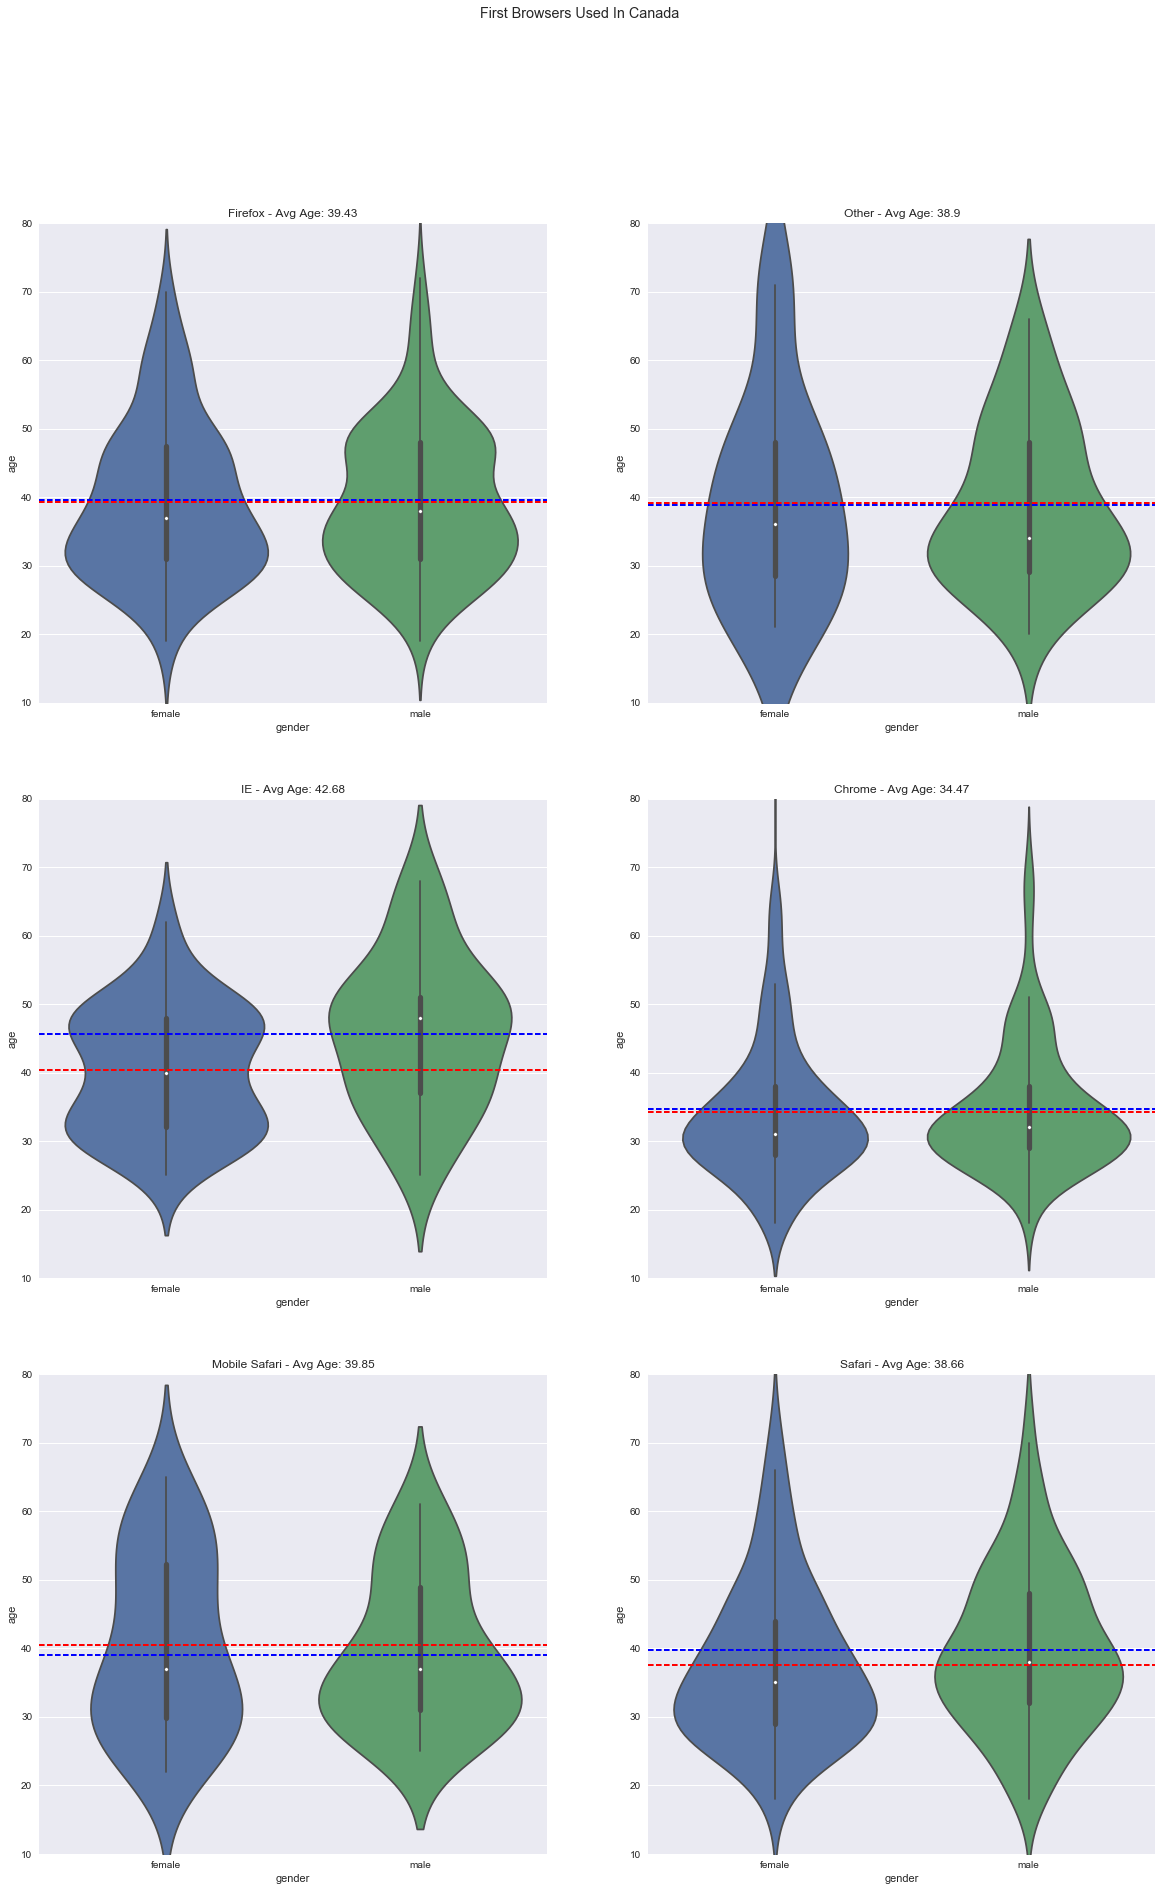

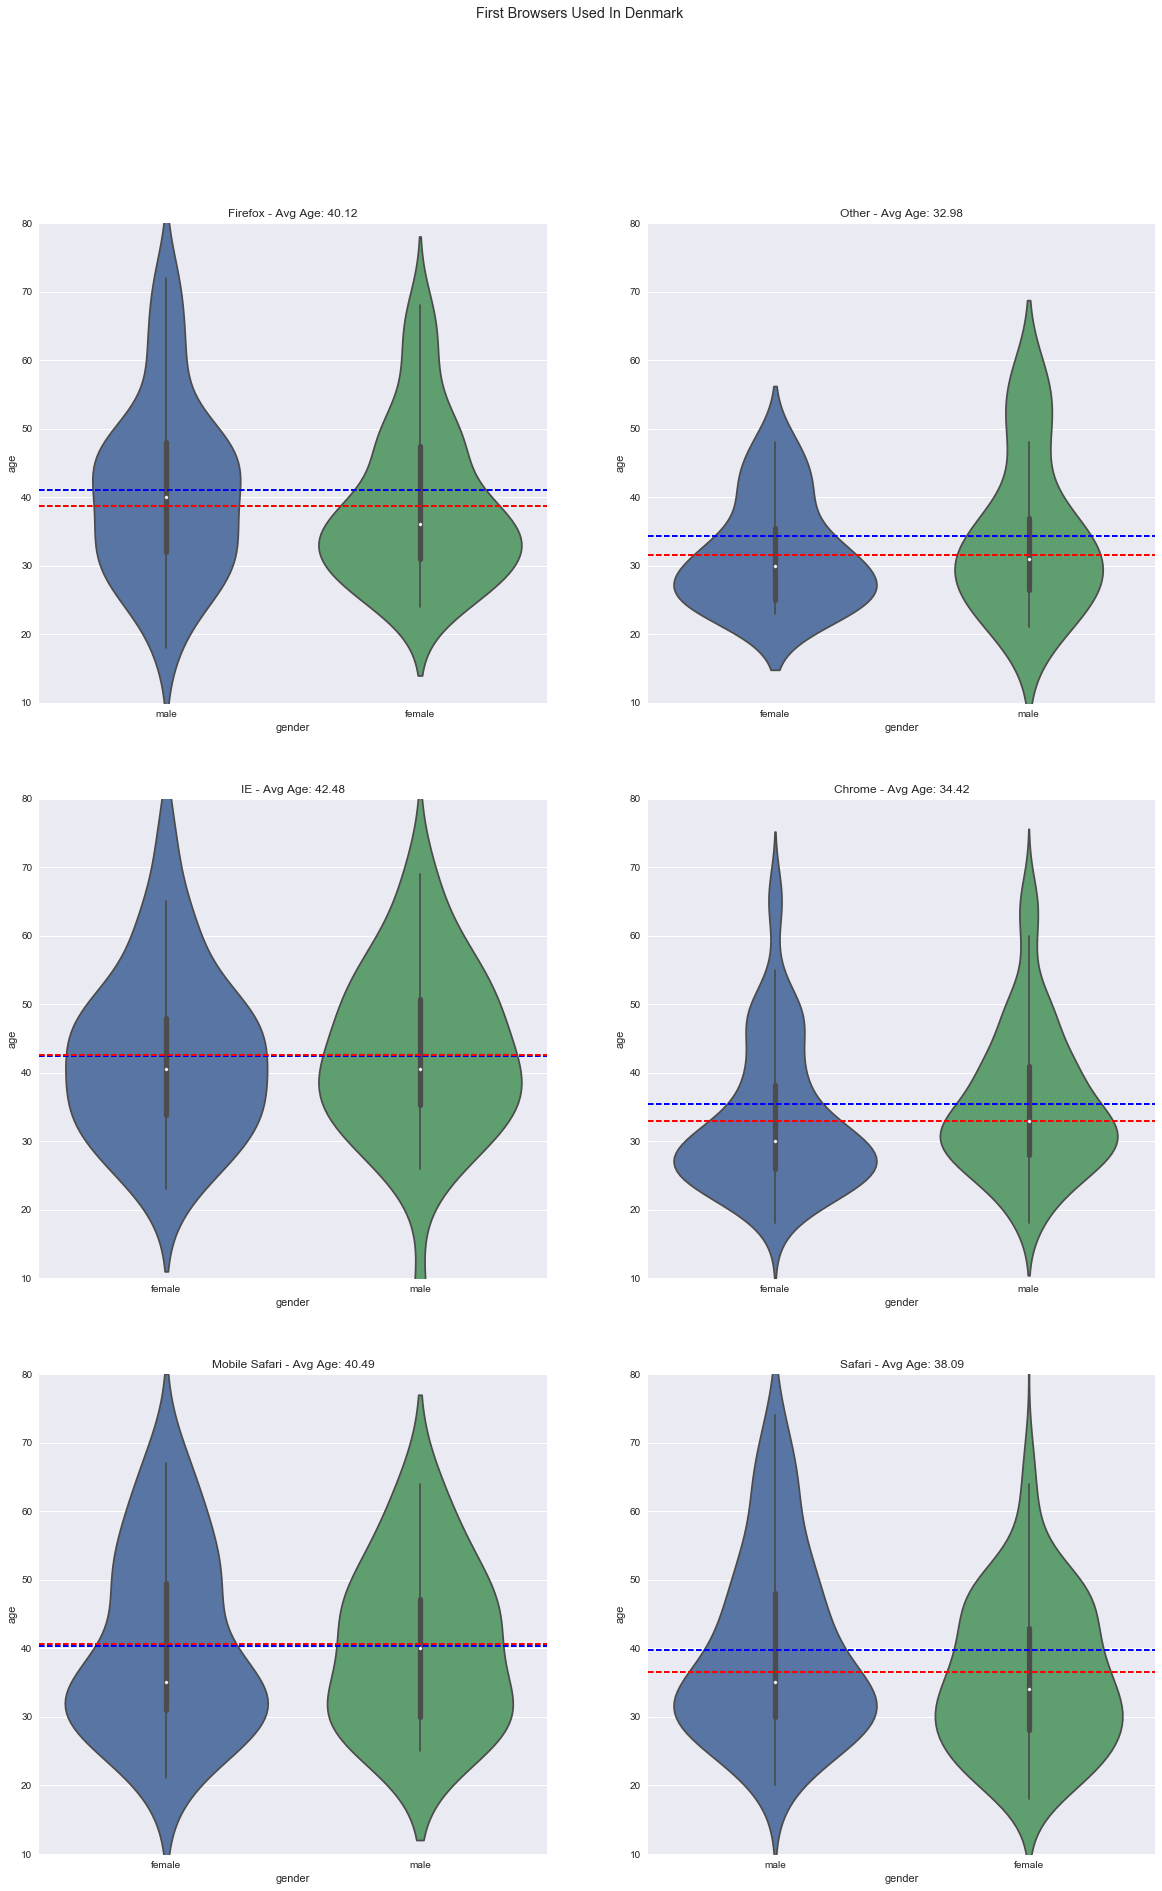

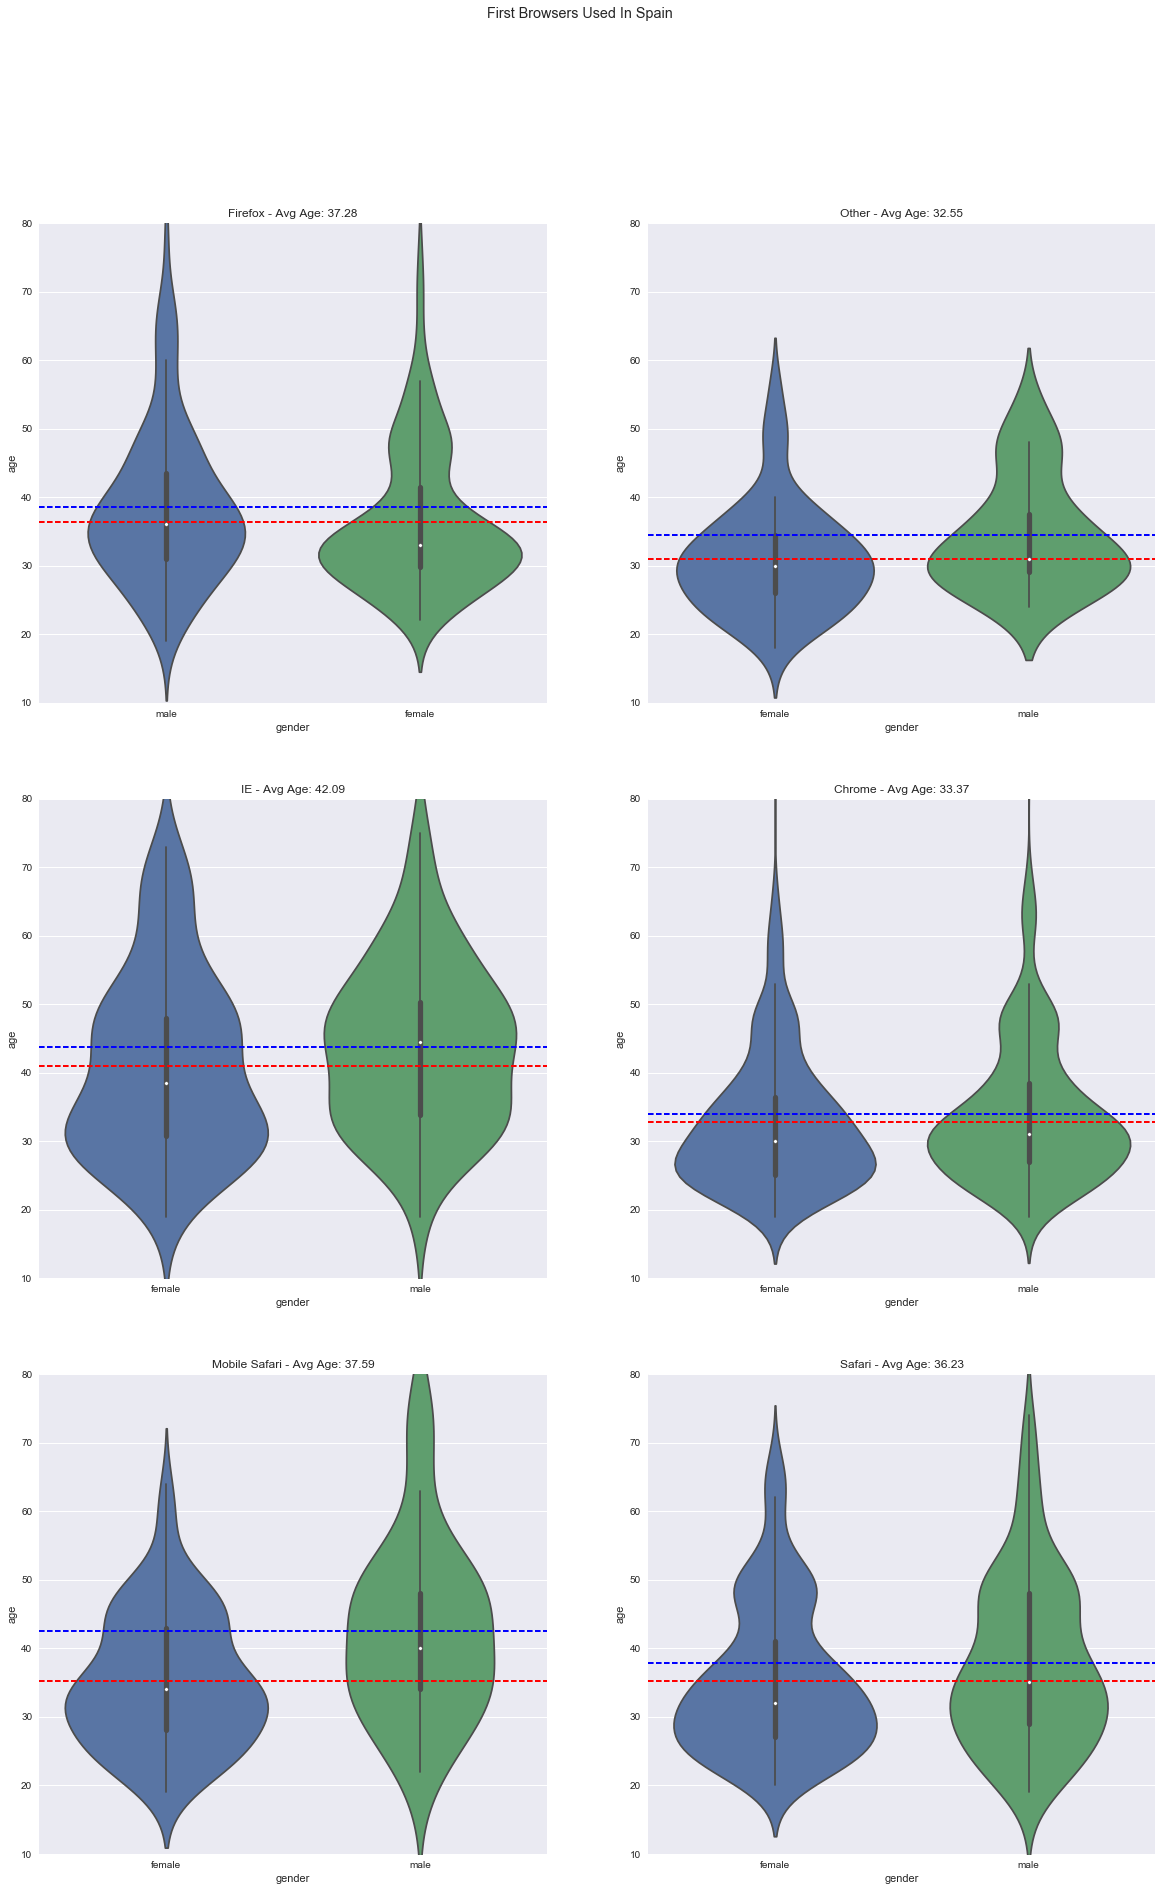

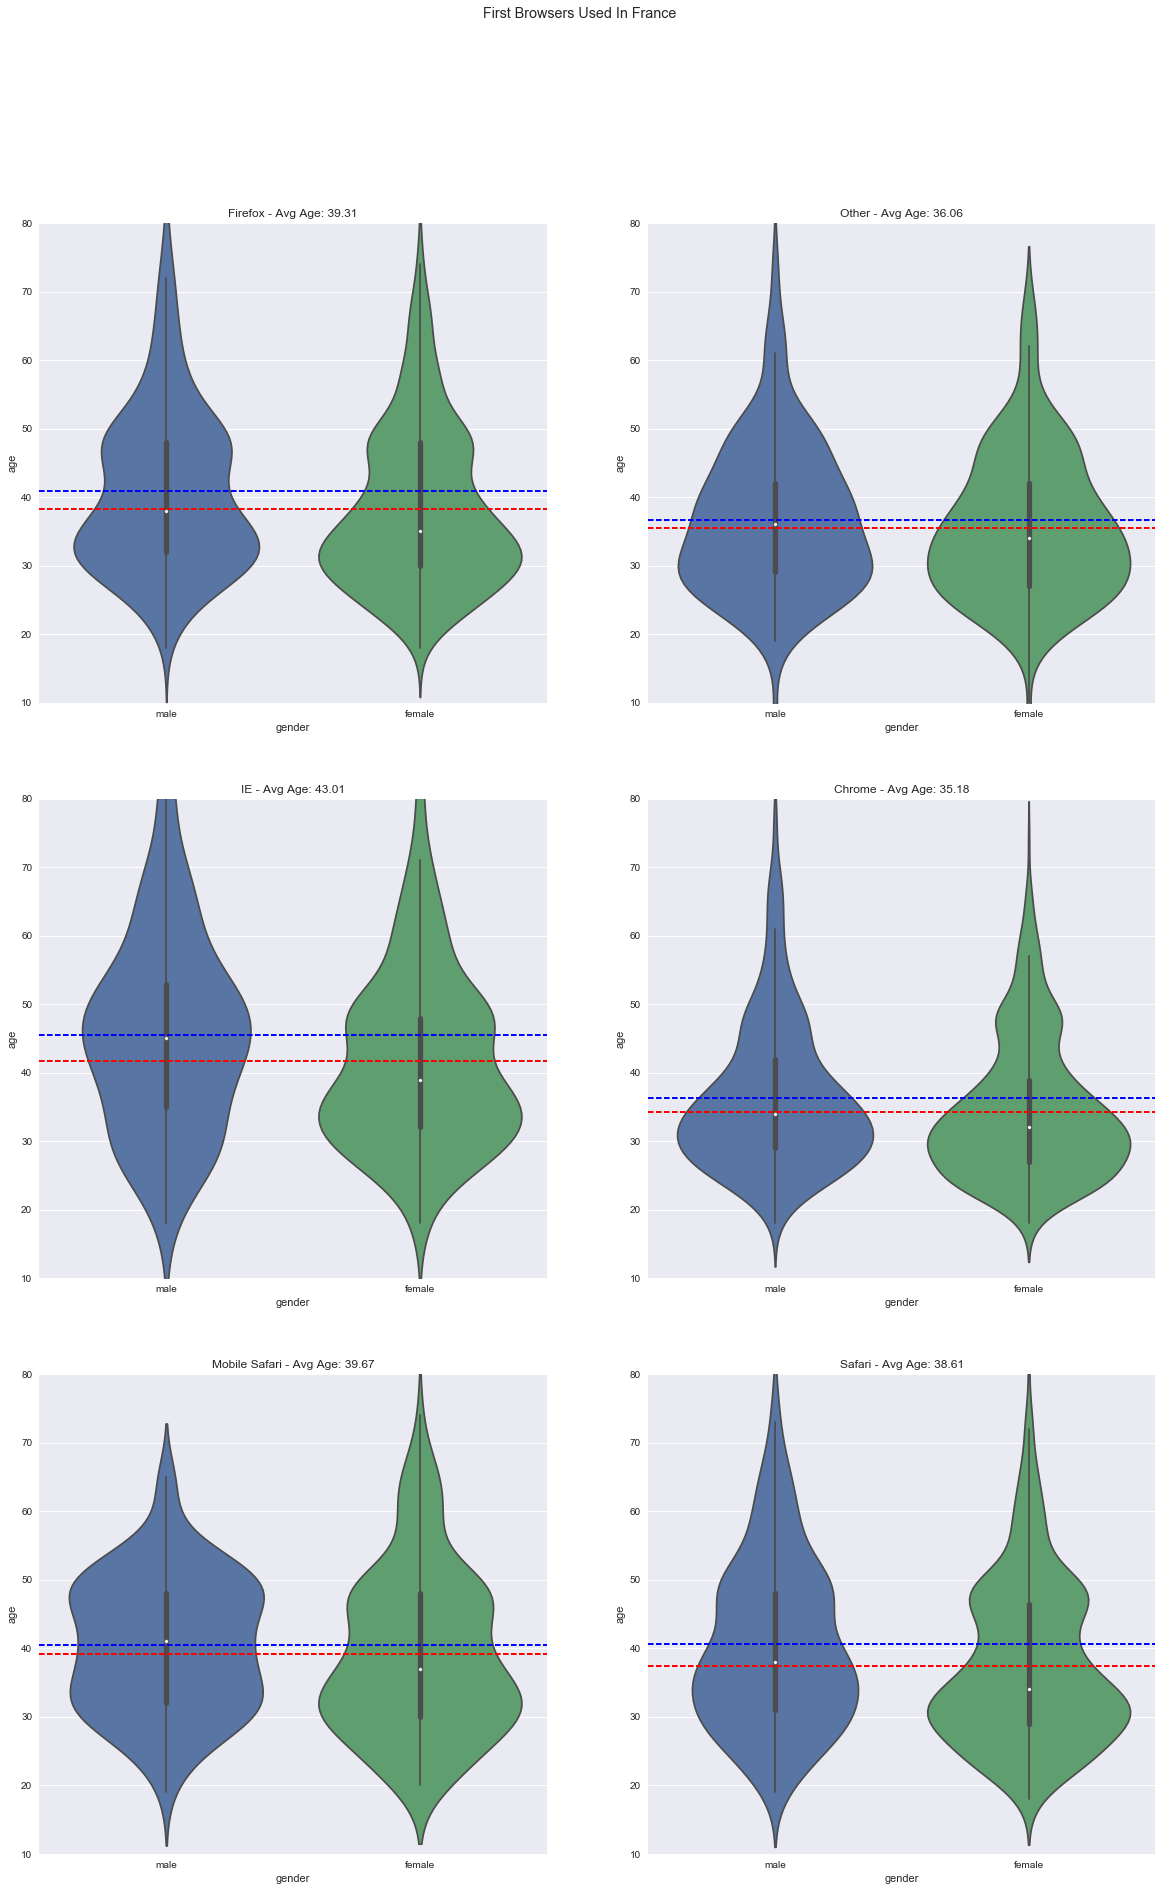

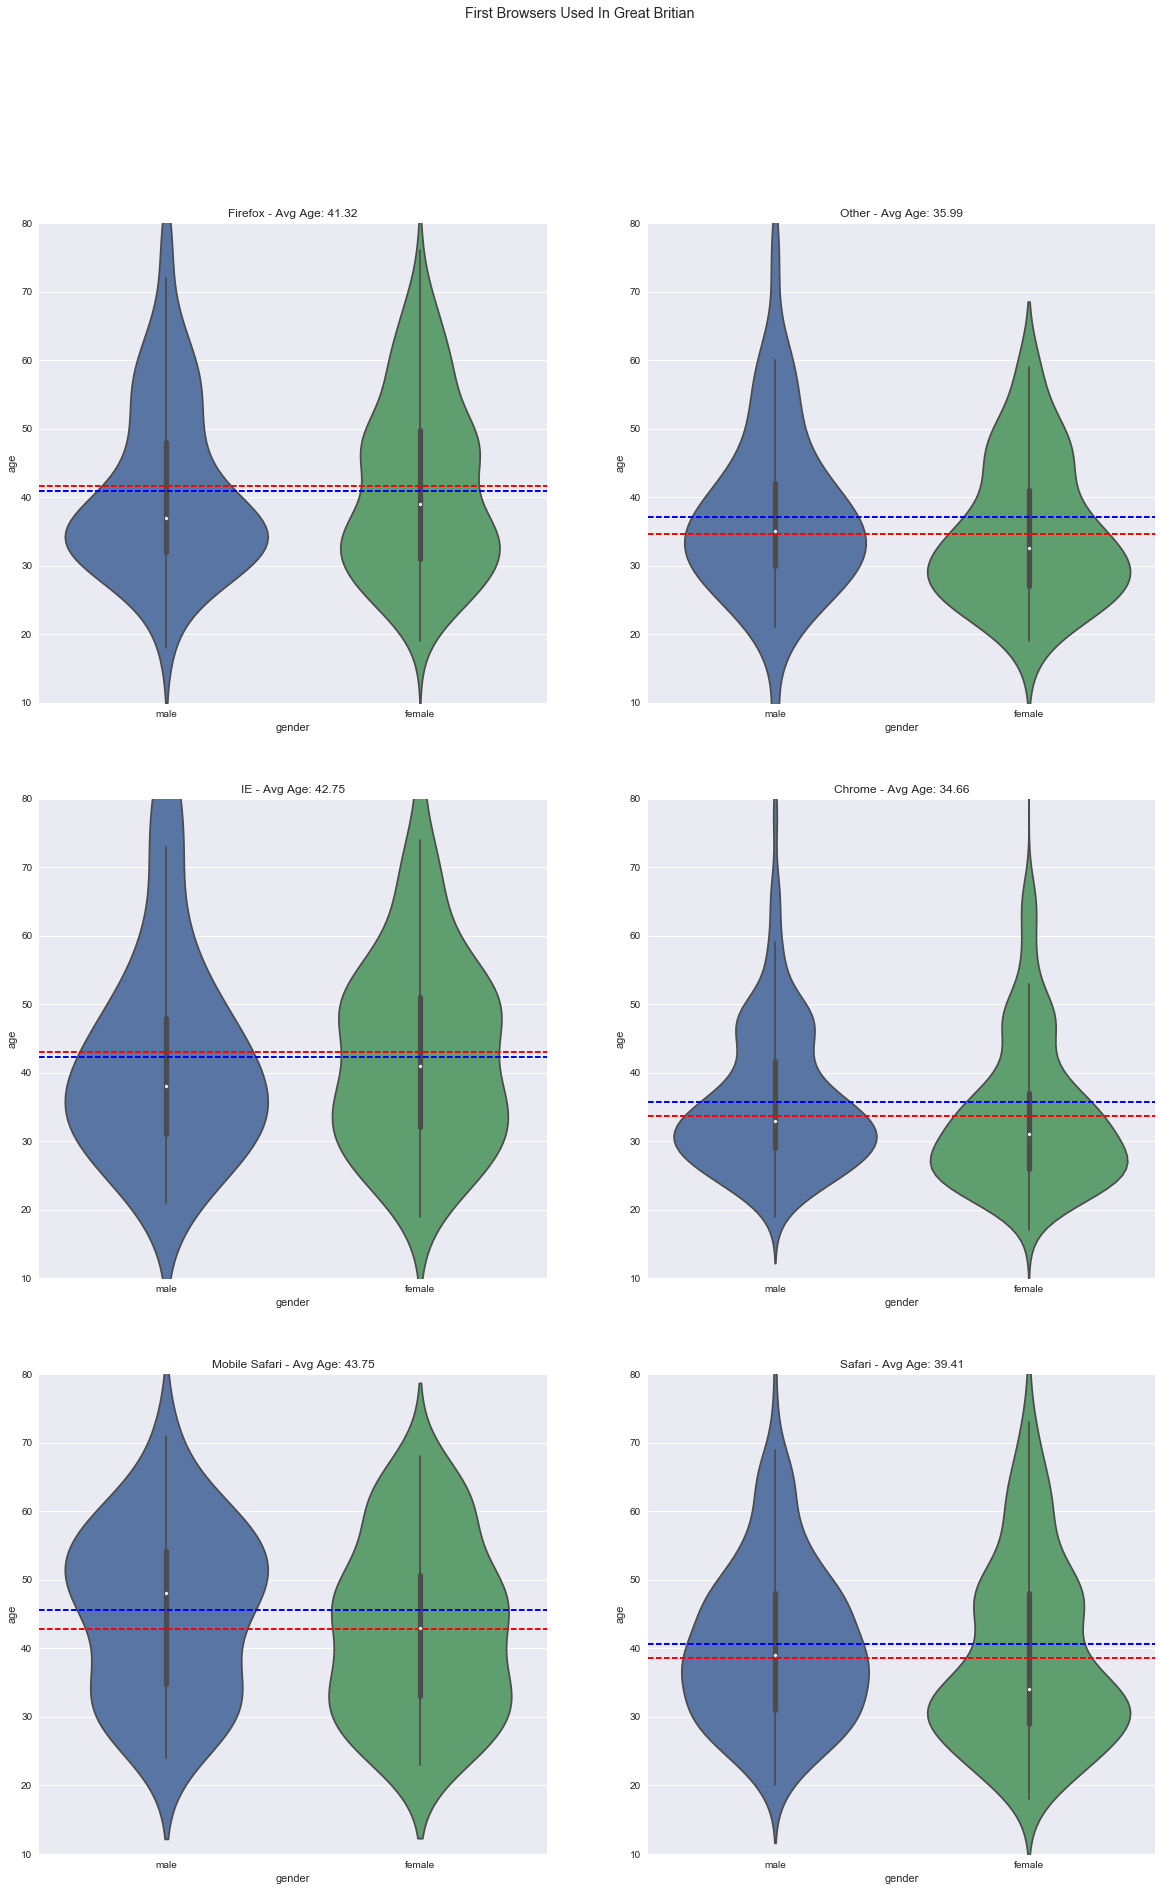

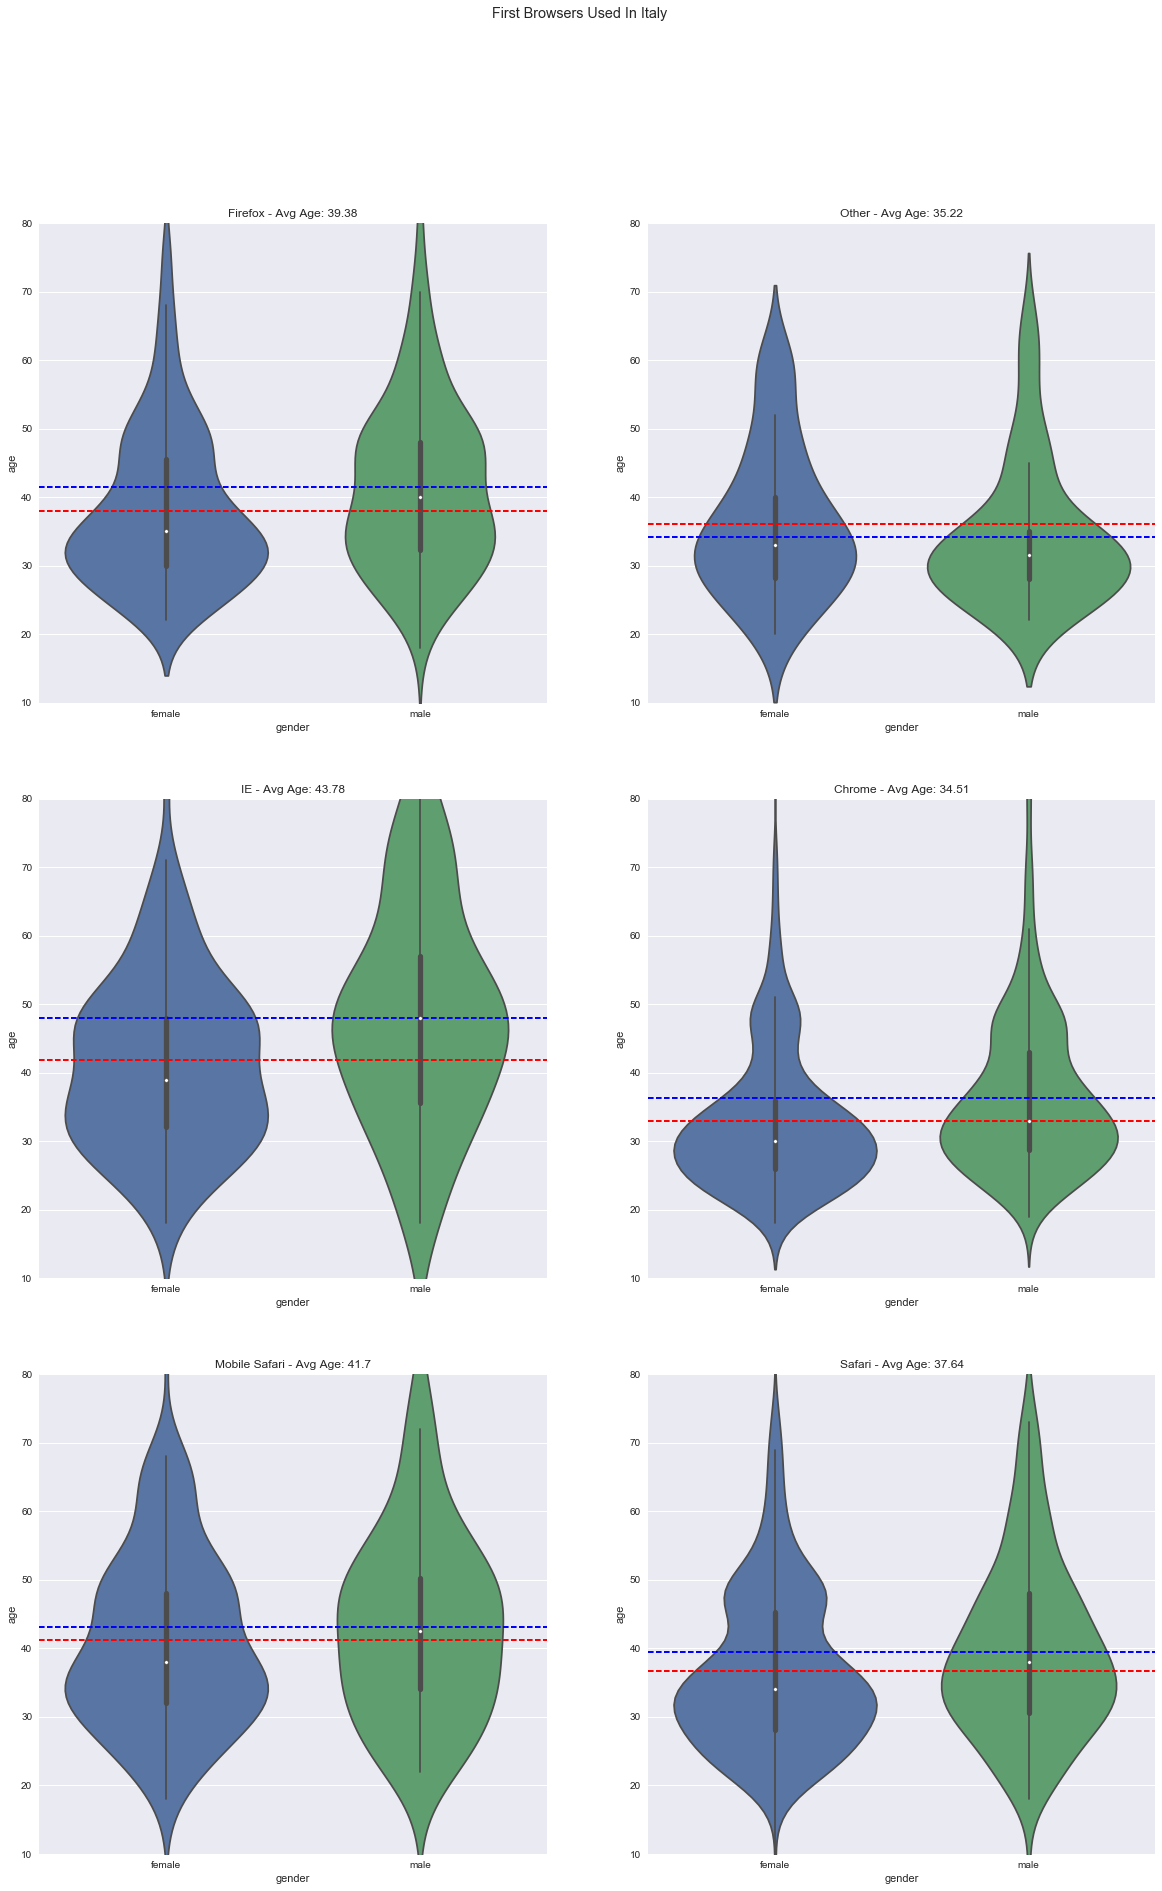

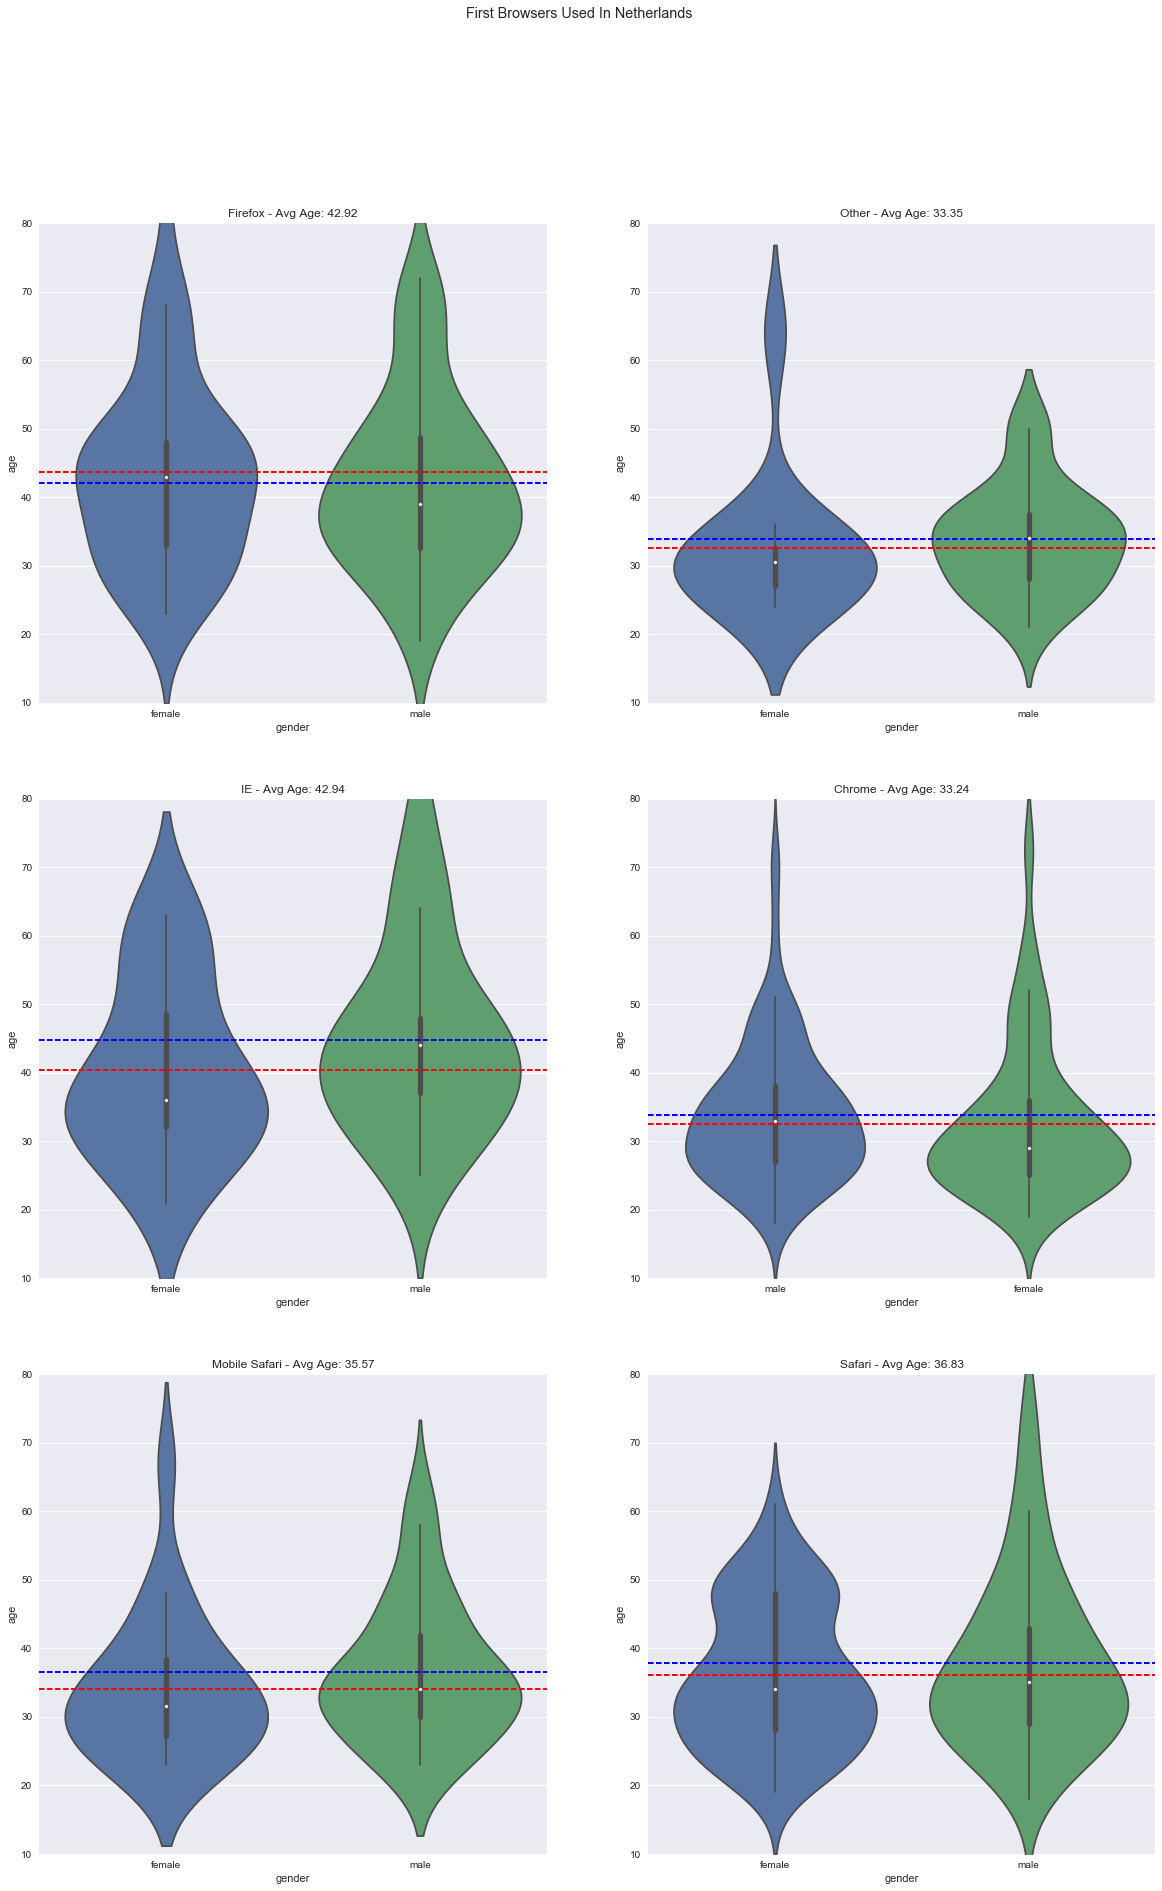

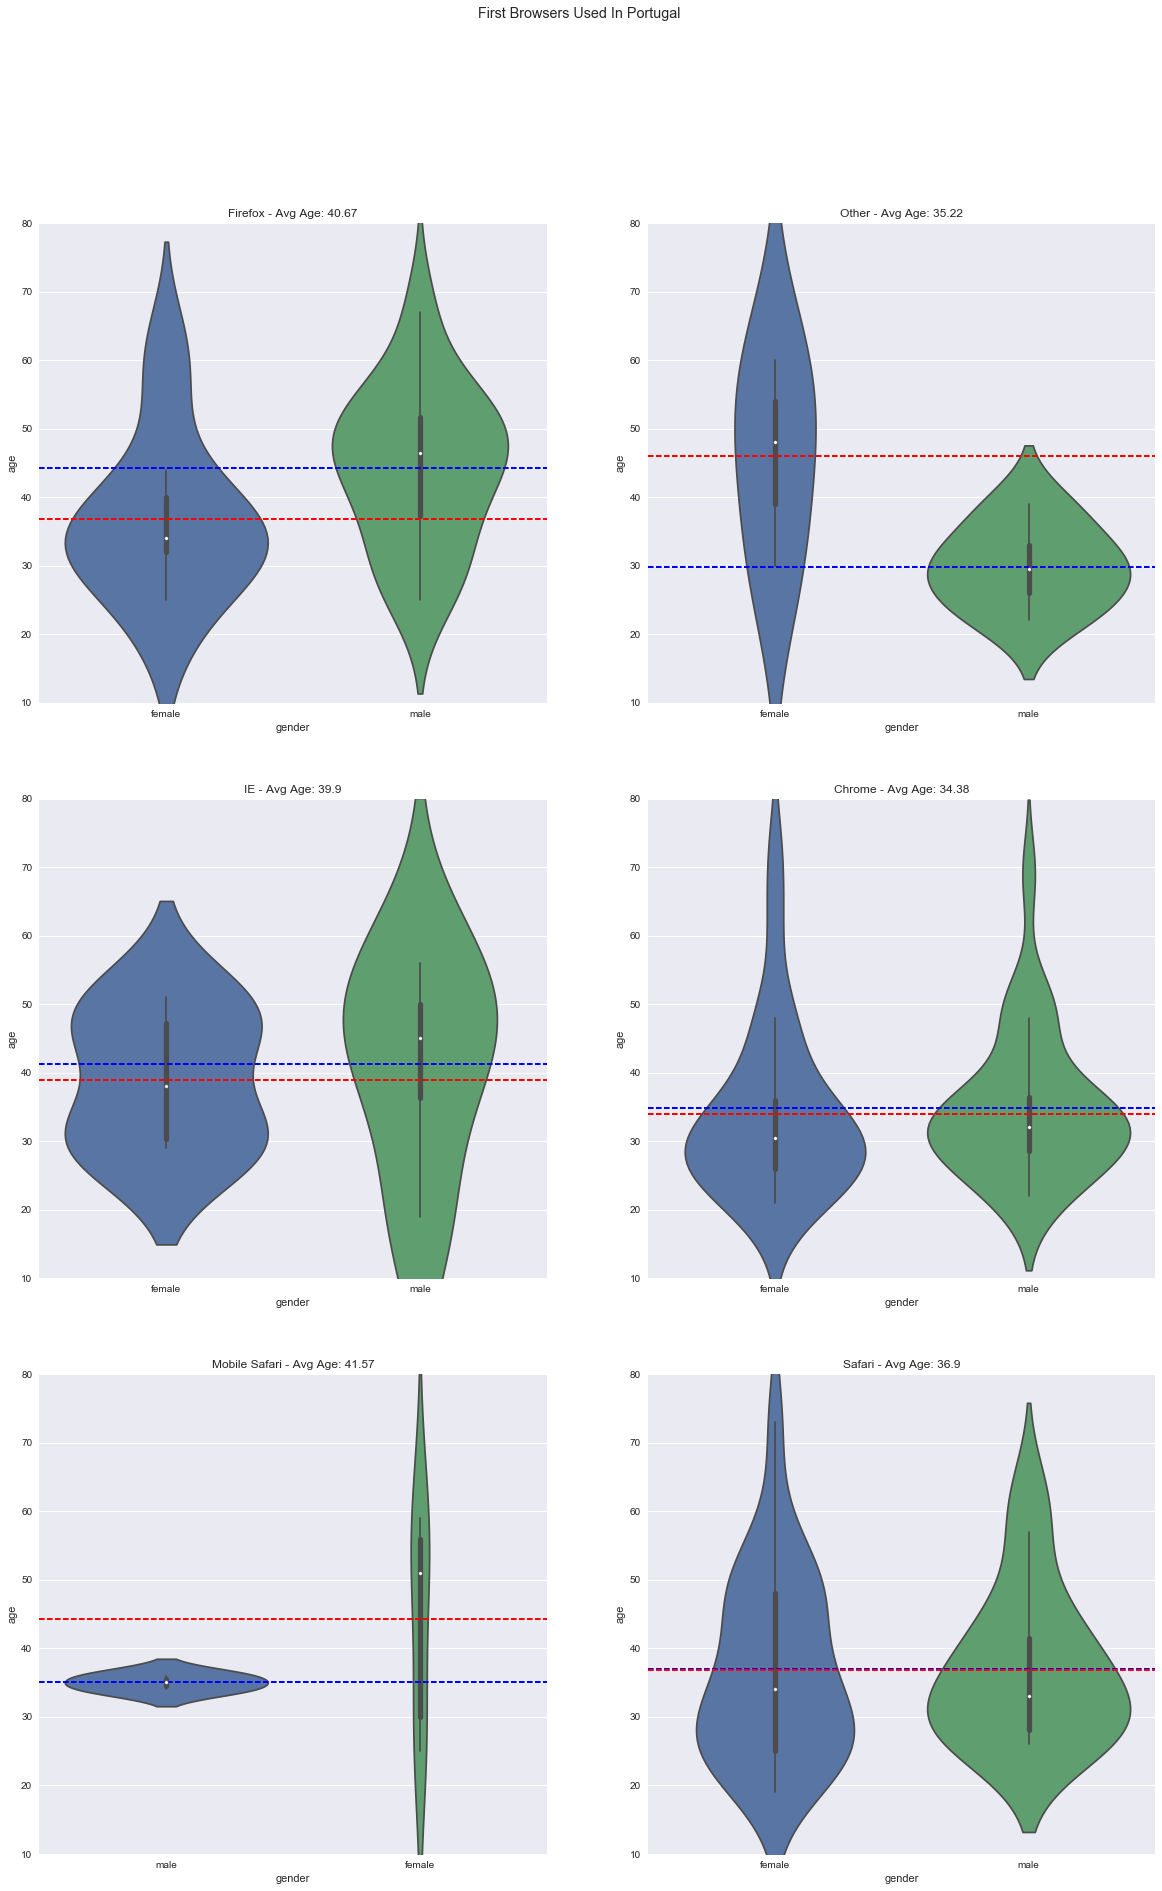

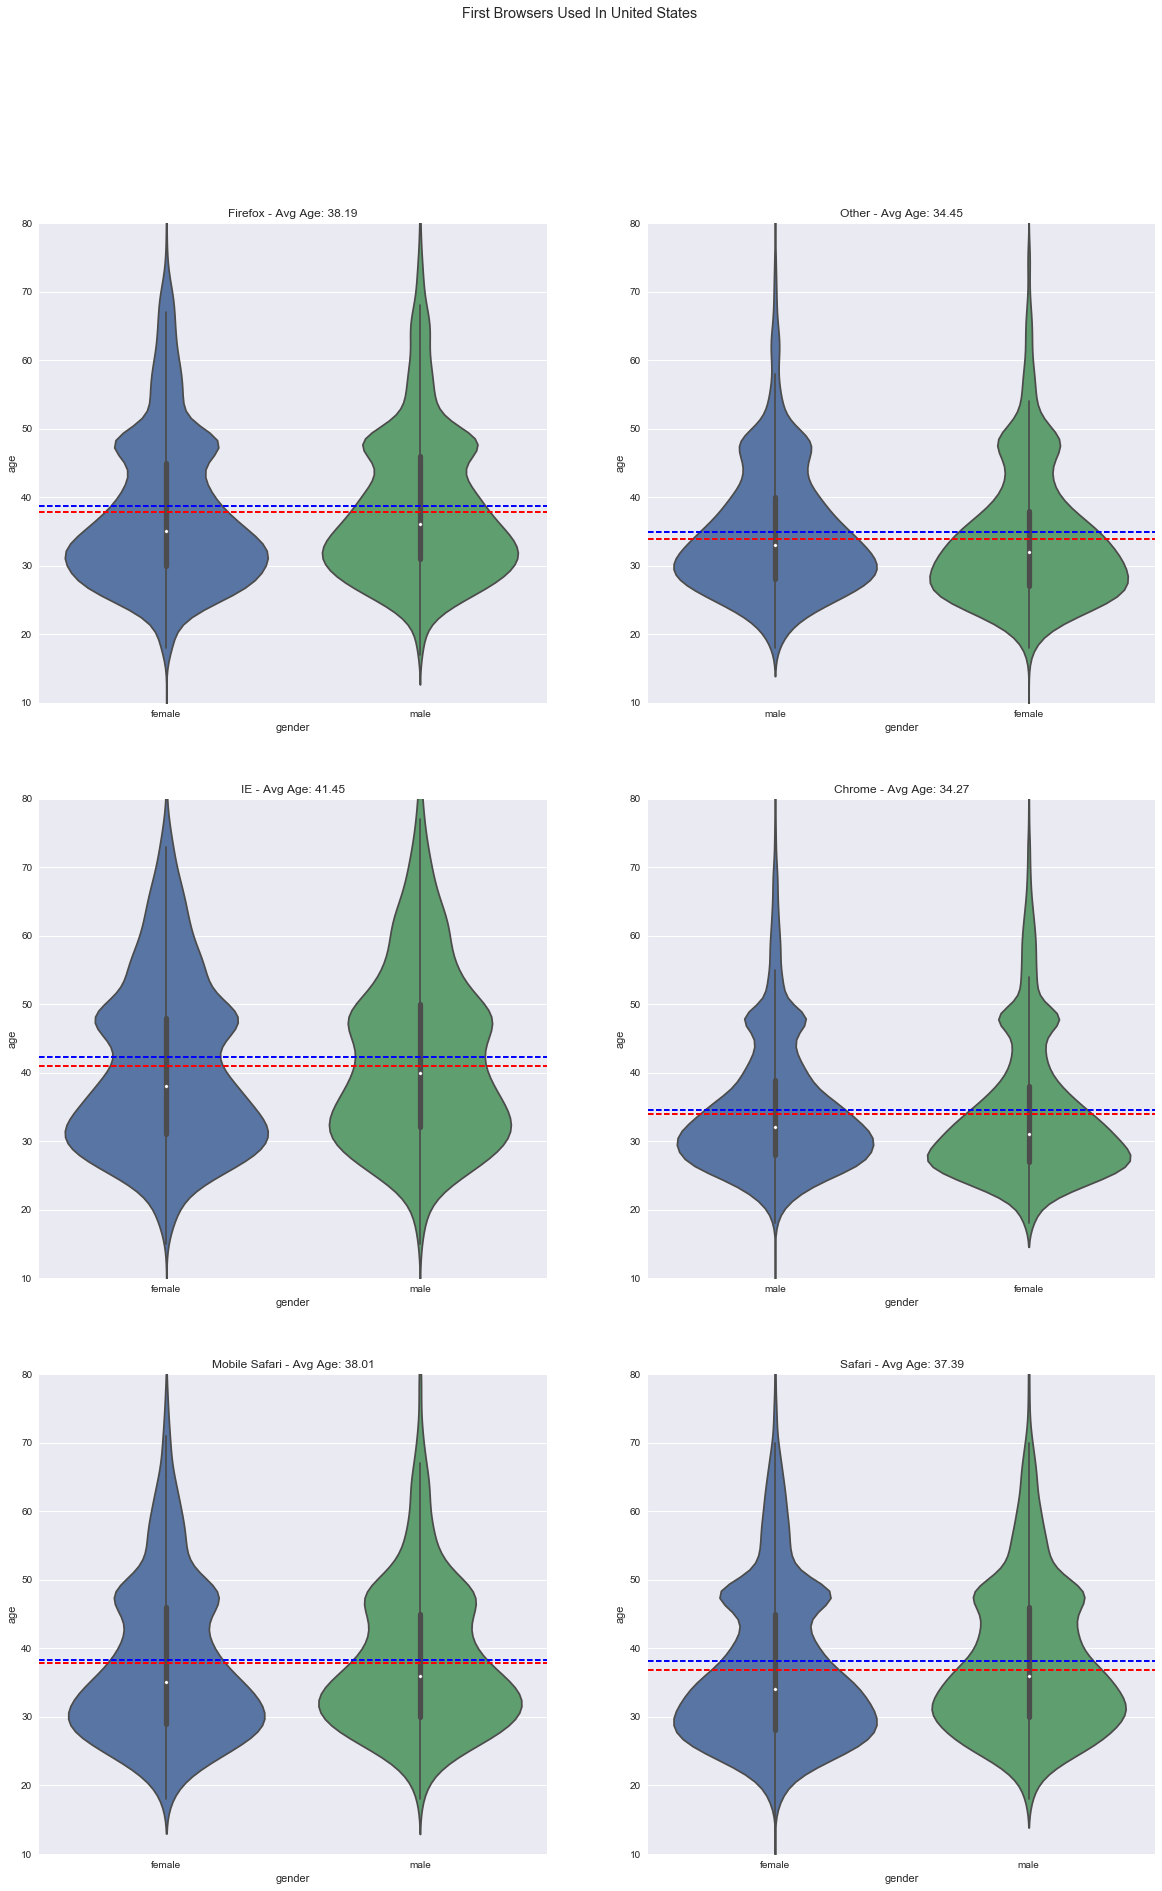

In [8]:
country_plots = 10
def country_buckets(i):
    return [ucb.country_destination.unique()[i]]

num_plots = 6
def buckets(i):
    return [ucb.first_browser.unique()[i]]

for x in range(country_plots):
    fig, axes = plt.subplots(3,2,figsize=(20,30))
    for i in range(num_plots):
        # Get all data for this browser, Google, and than filter it down by country
        data = ucb[ucb.first_browser.isin(buckets(i)) & ucb.country_destination.isin(country_buckets(x))]

        male_mean = data.loc[data['gender'] == 'male'].age.mean()
        female_mean = data.loc[data['gender'] == 'female'].age.mean()

        row = i // 2
        col = i % 2
        ax_curr = axes[row, col]

        title = buckets(i)[0]
        avg_age = round(data.age.mean(), 2)
        country_title = full_country_name[country_buckets(x)[0]]

        sns.violinplot(x="gender", y="age", data=data, ax=ax_curr) 
        ax_curr.set(ylim=(10, 80))
        ax_curr.set_title('{} - Avg Age: {}'.format(title, avg_age))
        ax_curr.axhline(male_mean, color='b', linestyle='dashed', linewidth=2)
        ax_curr.axhline(female_mean, color='r', linestyle='dashed', linewidth=2)

    fig.suptitle('First Browsers Used In {}'.format(country_title))
    plt.show()

# We can tell by the data that users for all countries who use Chrome are generally pretty young, and users for all countries who use IE are typically older. The might help us if we can find what age groups visit certain countries the most often. 

In [9]:
distance_fem = ucb.loc[ucb['gender'] == 'female']['distance_km'].mean()
distance_male = ucb.loc[ucb['gender'] == 'male']['distance_km'].mean()
'{} {}'.format(distance_male, distance_fem)
x = ['distance traveled by male', 'distance traveled by female']
y = [distance_male, distance_fem]

dist_under_18 = ucb.loc[ucb['age'] <= 18]['distance_km'].mean()
dist_19_25 = ucb.loc[ucb['age'] >= 19].loc[ucb['age'] < 26]['distance_km'].mean()
dist_26_31 = ucb.loc[ucb['age'] >= 26].loc[ucb['age'] < 32]['distance_km'].mean()
dist_32_40 = ucb.loc[ucb['age'] >= 32].loc[ucb['age'] < 41]['distance_km'].mean()
dist_41_50 = ucb.loc[ucb['age'] >= 41].loc[ucb['age'] < 51]['distance_km'].mean()
dist_51_60 = ucb.loc[ucb['age'] >= 51].loc[ucb['age'] < 61]['distance_km'].mean()
dist_61_up = ucb.loc[ucb['age'] >= 61]['distance_km'].mean()
x_age = ['>19', '19-25', '26-31', '32-40', '41-50', '51-60', '60+']
y_age = [dist_under_18, dist_19_25, dist_26_31, dist_32_40, dist_41_50, dist_51_60, dist_61_up]

su_facebook = ucb.loc[ucb['signup_method'] == 'facebook']['distance_km'].mean()
su_google = ucb.loc[ucb['signup_method'] == 'google']['distance_km'].mean()
su_basic = ucb.loc[ucb['signup_method'] == 'basic']['distance_km'].mean()
x_sup = ['Facebook', 'Google', 'Basic']
y_sup = [su_facebook, su_google, su_basic]

suapp_web = ucb.loc[ucb['signup_app'] == 'Web']['distance_km'].mean()
suapp_ios = ucb.loc[ucb['signup_app'] == 'iOS']['distance_km'].mean()
suapp_android = ucb.loc[ucb['signup_app'] == 'Moweb']['distance_km'].mean()
suapp_moweb = ucb.loc[ucb['signup_app'] == 'Android']['distance_km'].mean()
x_suapp = ['Web', 'iOS', 'Android', 'Moweb']
y_suapp = [suapp_web, suapp_ios, suapp_android, suapp_moweb]

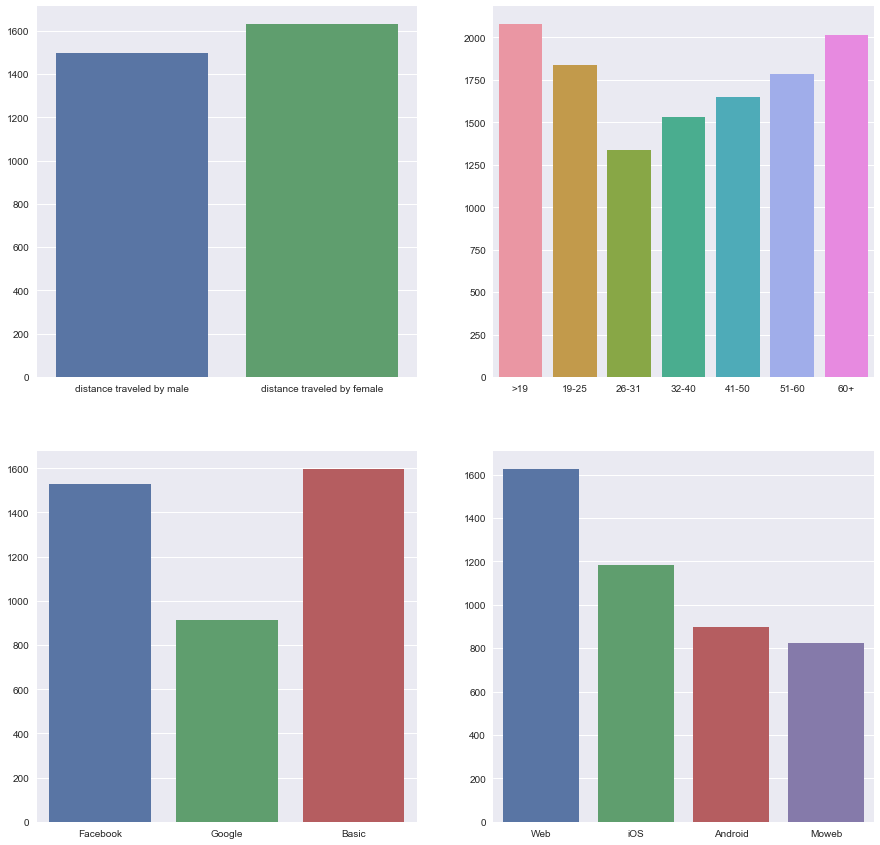

In [10]:
num_plots = 4
fig, axes = plt.subplots(2,2,figsize=(15,15))

sns.barplot(x, y, ax=axes[0, 0])
sns.barplot(x_age, y_age, ax=axes[0, 1])
sns.barplot(x_sup, y_sup, ax=axes[1, 0])
sns.barplot(x_suapp, y_suapp, ax=axes[1, 1])
plt.show()

In [11]:
ucb = ucb.sort_values('destination_km2', ascending=False)
fifths = ucb.iloc[0:1]['destination_km2'] / 5
fifths

1272    1996934.0
Name: destination_km2, dtype: float64

In [12]:
x_small = ucb.loc[ucb['destination_km2'] < 2000000].age.mean()
small = ucb.loc[ucb['destination_km2'] >= 2000000].loc[ucb['destination_km2'] < 4000000]
medium = ucb.loc[ucb['destination_km2'] >= 4000000].loc[ucb['destination_km2'] < 6000000]
large = ucb.loc[ucb['destination_km2'] >= 6000000].age.mean()

def getCountrySize(row):
    if row['destination_km2'] < 5000000:
        return 'small'
    else:
        return 'large'

ucb['size_dest'] = ucb.apply(lambda x: getCountrySize(x), axis=1)
ucb.head(5)

,country_destination,gender,dest_age_pop,age,id,date_account_created,timestamp_first_active,date_first_booking,signup_method,signup_flow,...,FR,IT,GB,ES,CA,DE,NL,AU,PT,size_dest
1272,CA,male,1189000,37,yc91zll8k2,2013-06-12,20130612062305,2013-07-03,basic,0,...,0,0,0,0,1,0,0,0,0,large
884,CA,female,1217000,48,9qisbr35xd,2012-06-30,20120630160640,2012-06-30,basic,3,...,0,0,0,0,1,0,0,0,0,large
882,CA,female,1217000,48,pmmjdbp7j7,2012-05-08,20120508230220,2012-05-09,basic,3,...,0,0,0,0,1,0,0,0,0,large
881,CA,female,1217000,48,e9kvwi5w2u,2012-05-07,20120507173830,2012-05-07,basic,0,...,0,0,0,0,1,0,0,0,0,large
880,CA,female,1217000,48,h6uw23xl6h,2012-05-03,20120503093608,2012-05-04,basic,12,...,0,0,0,0,1,0,0,0,0,large


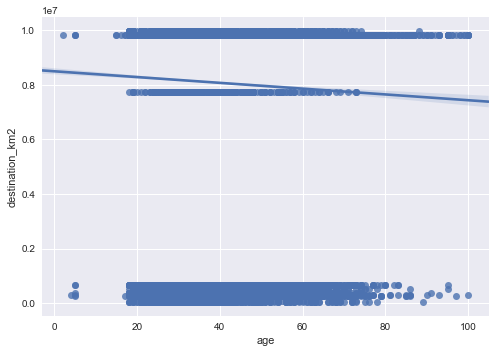

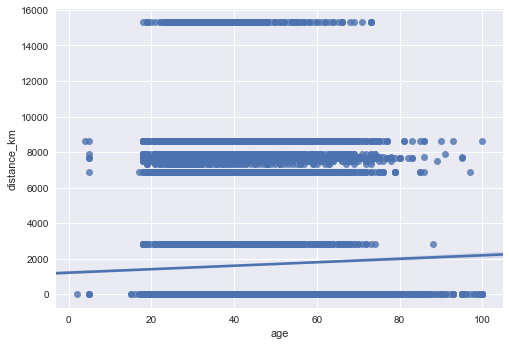

In [13]:
des = sns.regplot('age', 'destination_km2', data=ucb)
plt.show()

dis = sns.regplot('age', 'distance_km', data=ucb)
plt.show()

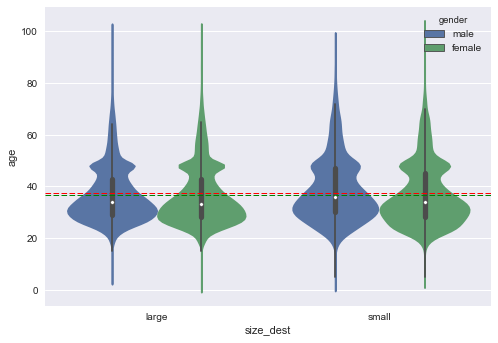

37.499318157977555

In [14]:
dest = sns.violinplot('size_dest', 'age', data=ucb, hue='gender')
dest.axhline(x_small, color='r', linestyle='dashed', linewidth=1)
dest.axhline(large, color='g', linestyle='dashed', linewidth=1)
plt.show()

x_small

## It is faint but there is some correlation between country size, and getting older. The older you get, it seems more likely that you will visit a small country

<h1 style="color: red">Model Fitting</h1>

In [15]:
ucb = pd.read_csv('clean_airbnb.csv')

In [16]:
ucb = ucb.drop(["FR", "IT", "US", "ES", "CA", "GB", "DE", "NL", "AU", "PT"], axis=1)

sex_1hot = pd.get_dummies(ucb['gender'])
su_method_1hot = pd.get_dummies(ucb['signup_method'])
fa_tracked_1hot = pd.get_dummies(ucb['first_affiliate_tracked'])
su_app_1hot = pd.get_dummies(ucb['signup_app'])
dev_type_1hot = pd.get_dummies(ucb['first_device_type'])
first_brwsr_1hot = pd.get_dummies(ucb['first_browser'])
dst_lang_1hot = pd.get_dummies(ucb['language'])
aff_chn_1hot = pd.get_dummies(ucb['affiliate_channel'])
# aff_prv_1hot = pd.get_dummies(ucb['affiliate_provider'])
dst_lng_1hot = pd.get_dummies(ucb['destination_language '])

ucb = ucb.drop('gender', axis=1)
ucb = ucb.drop('signup_method', axis=1)
ucb = ucb.drop('first_affiliate_tracked', axis=1)
ucb = ucb.drop('signup_app', axis=1)
ucb = ucb.drop('first_device_type', axis=1)
ucb = ucb.drop('first_browser', axis=1)
ucb = ucb.drop('language', axis=1)
ucb = ucb.drop('affiliate_channel', axis=1)
# ucb = ucb.drop('affiliate_provider', axis=1)
ucb = ucb.drop('destination_language ', axis=1)

ucb = ucb.join(sex_1hot)
ucb = ucb.join(su_method_1hot)
ucb = ucb.join(fa_tracked_1hot)
ucb = ucb.join(su_app_1hot)
ucb = ucb.join(dev_type_1hot)
ucb = ucb.join(first_brwsr_1hot)
ucb = ucb.join(dst_lang_1hot)
ucb = ucb.join(aff_chn_1hot)
# ucb = ucb.join(aff_prv_1hot)
ucb = ucb.join(dst_lng_1hot)

ucb = ucb.drop('affiliate_provider', axis=1)
ucb = ucb.drop('date_first_booking', axis=1)
ucb = ucb.drop('date_account_created', axis=1)
ucb = ucb.drop('id', axis=1)

# Mental Note, see if month signing up has anything to do with country visited !!!

In [33]:
y = ucb['country_destination'].values
X = ucb.drop('country_destination', axis=1)

logrg = LogisticRegression()
logrg.fit(X, y)

pd.DataFrame(list(zip(X.columns, logrg.coef_[0])), columns = ['features', 'estimatedCoefficients'])

,features,estimatedCoefficients
0,dest_age_pop,-1.734628e-19
1,age,-4.358475e-25
2,timestamp_first_active,-2.432295e-13
3,signup_flow,-3.215767e-26
4,lat_destination,-1.006468e-24
5,lng_destination,2.645829e-24
6,distance_km,9.412853e-23
7,destination_km2,-1.010120e-19
8,female,-6.711701e-27
9,male,-5.371529e-27


In [109]:
rfe = RFE(estimator=logrg, n_features_to_select=7, step=1)
rfe.fit(X, y)
ranking = rfe.ranking_
pd.DataFrame(list(zip(X.columns, ranking)), columns=['features', 'ranking'])

,features,ranking
0,dest_age_pop,1
1,age,1
2,timestamp_first_active,1
3,signup_flow,2
4,lat_destination,1
5,lng_destination,1
6,distance_km,1
7,destination_km2,1
8,female,8
9,male,11


## About 79% Accuracy

In [32]:
# Timestamp, dest_age_pop, destination_km2, distance_km, lng_destination, lat_destination, age
logreg = LogisticRegression()

y = ucb['country_destination'].values
X = ucb.drop('country_destination', axis=1)
X = X[['timestamp_first_active', 'dest_age_pop', 'destination_km2']]

score = []
for x in range(10):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, stratify=y)
    logreg.fit(X_train, y_train)
    score.append(logreg.score(X_test, y_test))

# score = np.array(score).mean()
score

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3, stratify=y)
# logreg.fit(X_train, y_train)
    
# prediction = logreg.predict(X_test)

# print(classification_report(y_test, prediction))

# Values just stay the same ?

[0.79353532797773418,
 0.79353532797773418,
 0.79353532797773418,
 0.79353532797773418,
 0.79353532797773418,
 0.79353532797773418,
 0.79353532797773418,
 0.79353532797773418,
 0.79353532797773418,
 0.79353532797773418]

# Insights from EDA.
### Having made these plots, what are some insights you get from them? Do you see any correlations? Is there a hypothesis you would like to investigate further? What other questions do they lead you to ask?

* ### 1) There is a slight correlation between users age and how far they will travel from home, the youngest "Under 18" and the oldest "Over 60" traveling the farthest from home.
* ### 2) This goes for the size of the country as well, with users going to smaller and smaller countries as they grow older.
* ### 3) Bookings to the United States are on the rise, and those bookings to the US on average are getting younger and younger.
* ### 4) There is a spike in users who go to Australia in the winter months of the northern hemsiphere "Undoubtedly from the season inverse".